## **Predictive Modeling, Explainable AI, and Phenotypic Discovery for Long-Term Glycemic Control in New-Onset Diabetes**

### **Section 0: Introduction & Project Setup**

### **0.1. Introduction**

**Clinical Problem:** Diabetes Mellitus is a global health crisis characterized by chronic hyperglycemia, leading to severe long-term complications if not properly managed. Achieving and maintaining long-term glycemic control is the cornerstone of diabetes care, yet it remains a significant challenge. Early identification of patients at high risk for future poor glycemic control is critical, as it allows clinicians to implement more intensive and personalized management strategies from the outset. However, traditional risk stratification often relies on a limited set of clinical factors.

**Research Questions:** This project leverages a large, real-world dataset of new-onset diabetes patients to answer three key questions through a multi-phase, data-driven approach:
1.  **Prediction:** Can we build a high-performance machine learning model to accurately predict a patient's 3-year glycemic control status using only data available within the first year of diagnosis?
2.  **Explanation:** If such a model can be built, what are the most important clinical and biochemical factors driving its predictions? Can we move beyond a "black box" to understand the model's clinical logic?
3.  **Discovery:** Beyond individual risk prediction, can we use unsupervised learning to discover novel, data-driven clinical phenotypes of new-onset diabetes, and do these subgroups exhibit different long-term prognoses?

**Dataset:** The analysis is based on a public dataset from Gulkesen et al. (2024), compiled from the Turkish national electronic health record system (e-Nabız). It includes 77,724 patients newly diagnosed with diabetes in Istanbul in 2017. The dataset contains 105 variables recorded at diagnosis or within the first year, including demographics, lab results, comorbidities, and medications. The primary outcome is a binary variable, `Glycemic_control`, indicating whether a patient's HbA1c was consistently under 7% three years after diagnosis.

**Methodology Overview:** Our research follows a comprehensive three-phase plan:
*   **Phase 1: High-Performance Predictive Modeling:** We systematically develop and compare several machine learning models—from a simple logistic regression baseline to a complex neural network—to identify the most accurate predictor.
*   **Phase 2: Explainable AI (XAI):** We use the state-of-the-art SHAP (SHapley Additive exPlanations) framework to interpret our best-performing model, uncovering the key drivers behind its predictions on both a population and individual patient level.
*   **Phase 3: Phenotypic Discovery:** We employ unsupervised learning techniques (UMAP and HDBSCAN) to identify natural, data-driven patient subgroups and analyze their long-term outcomes, generating new hypotheses about the heterogeneity of diabetes.

In [1]:
# --- Core Libraries for Data Handling and Visualization ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Libraries for Predictive Modeling (Phase 1) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.calibration import CalibrationDisplay

# --- Libraries for Explainable AI (Phase 2) ---
# Suppress UserWarning from shap library on initialization
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
import shap

# --- Libraries for Phenotype Discovery (Phase 3) ---
import umap
import hdbscan
from scipy.stats import chi2_contingency

# --- General Notebook Configuration ---
# Set a consistent random state for reproducibility
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

# Set default plot style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Lower DPI for faster rendering in notebook

print("All libraries loaded successfully.")

All libraries loaded successfully.


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [2]:
# --- Load the Dataset ---

# URL for the dataset from Mendeley Data
url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/rr4rzzrjfc-2.zip'

# Load the specific CSV file from the ZIP archive into a pandas DataFrame
try:
    df = pd.read_csv(url, compression='zip', low_memory=False, sep=';', encoding='utf-8')
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Fallback to another common encoding if UTF-8 fails
    try:
        df = pd.read_csv(url, compression='zip', low_memory=False, sep=';', encoding='latin1')
        print("Dataset loaded successfully with 'latin1' encoding.")
    except Exception as e2:
        print(f"Failed to load dataset with fallback encoding: {e2}")

# Set the 'id' column as the index, as it is a unique patient identifier and not a predictive feature
if 'df' in locals() and 'id' in df.columns:
    df.set_index('id', inplace=True)
    print(f"'id' column has been set as the index. The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded successfully.
'id' column has been set as the index. The dataset has 77724 rows and 106 columns.


### **Section 1: Exploratory Data Analysis (EDA) - Understanding the Patient Cohort**

Before building complex models, it is essential to perform a thorough Exploratory Data Analysis (EDA). This process allows us to understand the fundamental characteristics of our patient cohort, check for data quality issues, and uncover initial relationships between variables that will inform our modeling strategy.

### **1.1. Initial Data Inspection**

First, we will perform a high-level inspection of the dataset to understand its structure, dimensions, and data types.

In [3]:
# Display the first 5 rows to get a feel for the data
print("First 5 rows of the dataset:")
display(df.head())

# Display the dimensions (rows, columns)
print(f"\nDataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")

# Display a concise summary of the DataFrame, including data types and non-null counts
print("\nDataset info:")
df.info()

First 5 rows of the dataset:


,HbA1c,Hba1c_change,sex,age,LDL,Cholesterol,HDL,Creatinine,Triglyceride,infectious_diseases,...,insulin_reguler,linagliptin,metformin_hcl,nateglinid,pioglitazon_hcl,repaglinide,saksagliptin,sitagliptin,vildagliptin,Glycemic_control
id,,,,,,,,,,,,,,,,,,,,,
0,10.3,0.234952,1,61,118.0,203.0,55.0,0.71,149.0,0,...,0.0,0.0,0.00,0.0,8.1,0.0,0.0,0.0,0.0,1
1,8.3,0.184793,2,65,92.0,189.0,63.0,1.01,253.0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1
2,8.0,0.174650,2,52,107.2,180.0,48.0,1.37,124.0,0,...,0.0,0.0,0.67,0.0,0.0,2.7,0.0,0.0,0.0,0
3,7.4,-0.073273,2,55,80.0,168.0,36.0,0.99,261.0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5.9,-0.031106,1,53,171.0,251.0,58.0,0.77,112.0,0,...,0.0,0.0,0.54,0.0,0.0,0.0,0.0,0.0,0.0,0



Dataset dimensions: 77724 rows, 106 columns

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 77724 entries, 0 to 77723
Columns: 106 entries, HbA1c to Glycemic_control
dtypes: float64(28), int64(78)
memory usage: 63.4 MB


**Interpretation:**

The initial inspection confirms that our dataset contains **77,724 patients** and **106 features** (after setting the ID column as the index). A crucial finding is that there are **no missing values** in any column, as indicated by the "Non-Null Count" being equal to the total number of entries for every feature. This signifies an exceptionally clean dataset, which greatly simplifies our preprocessing pipeline. The data types are all numerical (`float64` or `int64`), making them directly suitable for machine learning algorithms.

### **1.2. Analysis of Clinical & Outcome Variables**

Next, we analyze the distributions of the core continuous clinical variables and, most importantly, our target variable, `Glycemic_control`. Understanding the baseline characteristics of the cohort and the balance between the outcome classes is fundamental for building and evaluating our models.

--- Descriptive Statistics for Continuous Variables ---


,count,mean,std,min,25%,50%,75%,max
age,77724.0,56.789550,12.522938,1.000000,49.000000,57.00,65.000000,101.000000
HbA1c,77724.0,7.755775,2.000097,3.800000,6.300000,7.20,8.800000,38.360000
LDL,77724.0,124.222039,39.541198,10.000000,97.000000,122.00,149.000000,349.000000
Cholesterol,77724.0,207.343616,47.994363,17.000000,174.000000,204.00,236.000000,875.000000
HDL,77724.0,47.350972,12.505822,12.000000,39.000000,46.00,54.000000,192.000000
Creatinine,77724.0,0.862587,0.770276,0.300000,0.650000,0.76,0.910000,25.000000
Triglyceride,77724.0,185.630193,127.275042,10.000000,111.000000,155.00,221.000000,1984.000000
Hba1c_change,77724.0,0.058024,0.316809,-3.996248,-0.063306,0.00,0.103335,7.308205



--- Analysis of the Outcome Variable (Glycemic_control) ---


,Count,Percentage
Glycemic_control,,
Poor Control,48933,62.96
Under Control,28791,37.04


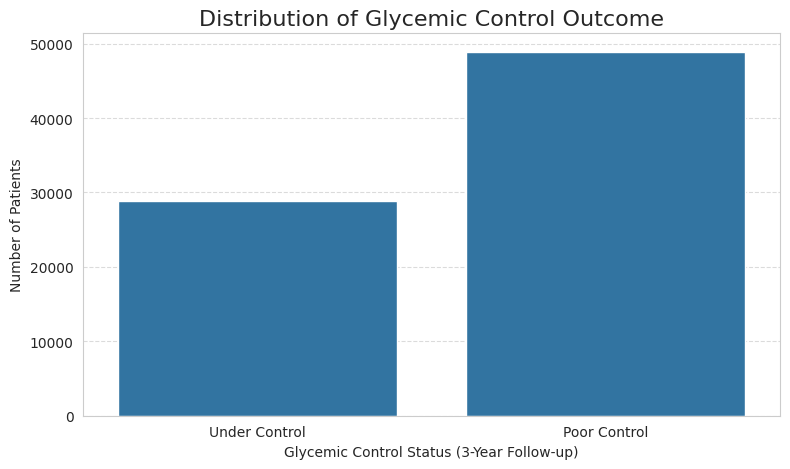

In [4]:
# Define the continuous variables for focused analysis
continuous_vars = [
    'age', 'HbA1c', 'LDL', 'Cholesterol', 'HDL', 'Creatinine',
    'Triglyceride', 'Hba1c_change'
]

# --- 1. Analyze Continuous Variables ---
print("--- Descriptive Statistics for Continuous Variables ---")
display(df[continuous_vars].describe().T)

# --- 2. Analyze the Outcome Variable ---
print("\n--- Analysis of the Outcome Variable (Glycemic_control) ---")
outcome_counts = df['Glycemic_control'].value_counts()
outcome_percentages = df['Glycemic_control'].value_counts(normalize=True) * 100

outcome_summary = pd.DataFrame({
    'Count': outcome_counts,
    'Percentage': outcome_percentages.round(2)
})
outcome_summary.index = outcome_summary.index.map({0: 'Under Control', 1: 'Poor Control'})
display(outcome_summary)

# --- 3. Visualize the Outcome Variable ---
plt.figure(figsize=(8, 5))
sns.countplot(x='Glycemic_control', data=df)
plt.title('Distribution of Glycemic Control Outcome', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Under Control', 'Poor Control'])
plt.xlabel('Glycemic Control Status (3-Year Follow-up)')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('glycemic_control_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The descriptive statistics reveal a cohort with a mean age at diagnosis of approximately **57 years** and a mean baseline **HbA1c of 7.76%**, confirming that these patients were indeed hyperglycemic at diagnosis.

The most critical finding from this step is the class distribution of our outcome variable. **Approximately 63% of patients are in the "Poor Control" class**, while **37% are "Under Control"**. This moderate class imbalance has two key strategic implications for our study:
1.  **Model Evaluation:** Standard accuracy will be a misleading metric. We must use metrics that are robust to class imbalance, such as the **Area Under the Receiver Operating Characteristic Curve (AUROC)** and the **Area Under the Precision-Recall Curve (AUPRC)**.
2.  **Data Splitting:** To ensure our models are trained and evaluated on representative data, we must use **stratified sampling** when creating our training, validation, and test sets.

### **1.3. Bivariate Analysis: Identifying Initial Predictors**

Having understood the individual variables, we now investigate their relationship with the outcome. This bivariate analysis helps us identify which factors show an initial, statistically significant association with long-term glycemic control. We will analyze the key continuous variables and the most prevalent comorbidities separately.

--- Bivariate Analysis: Continuous Variables vs. Glycemic Control ---


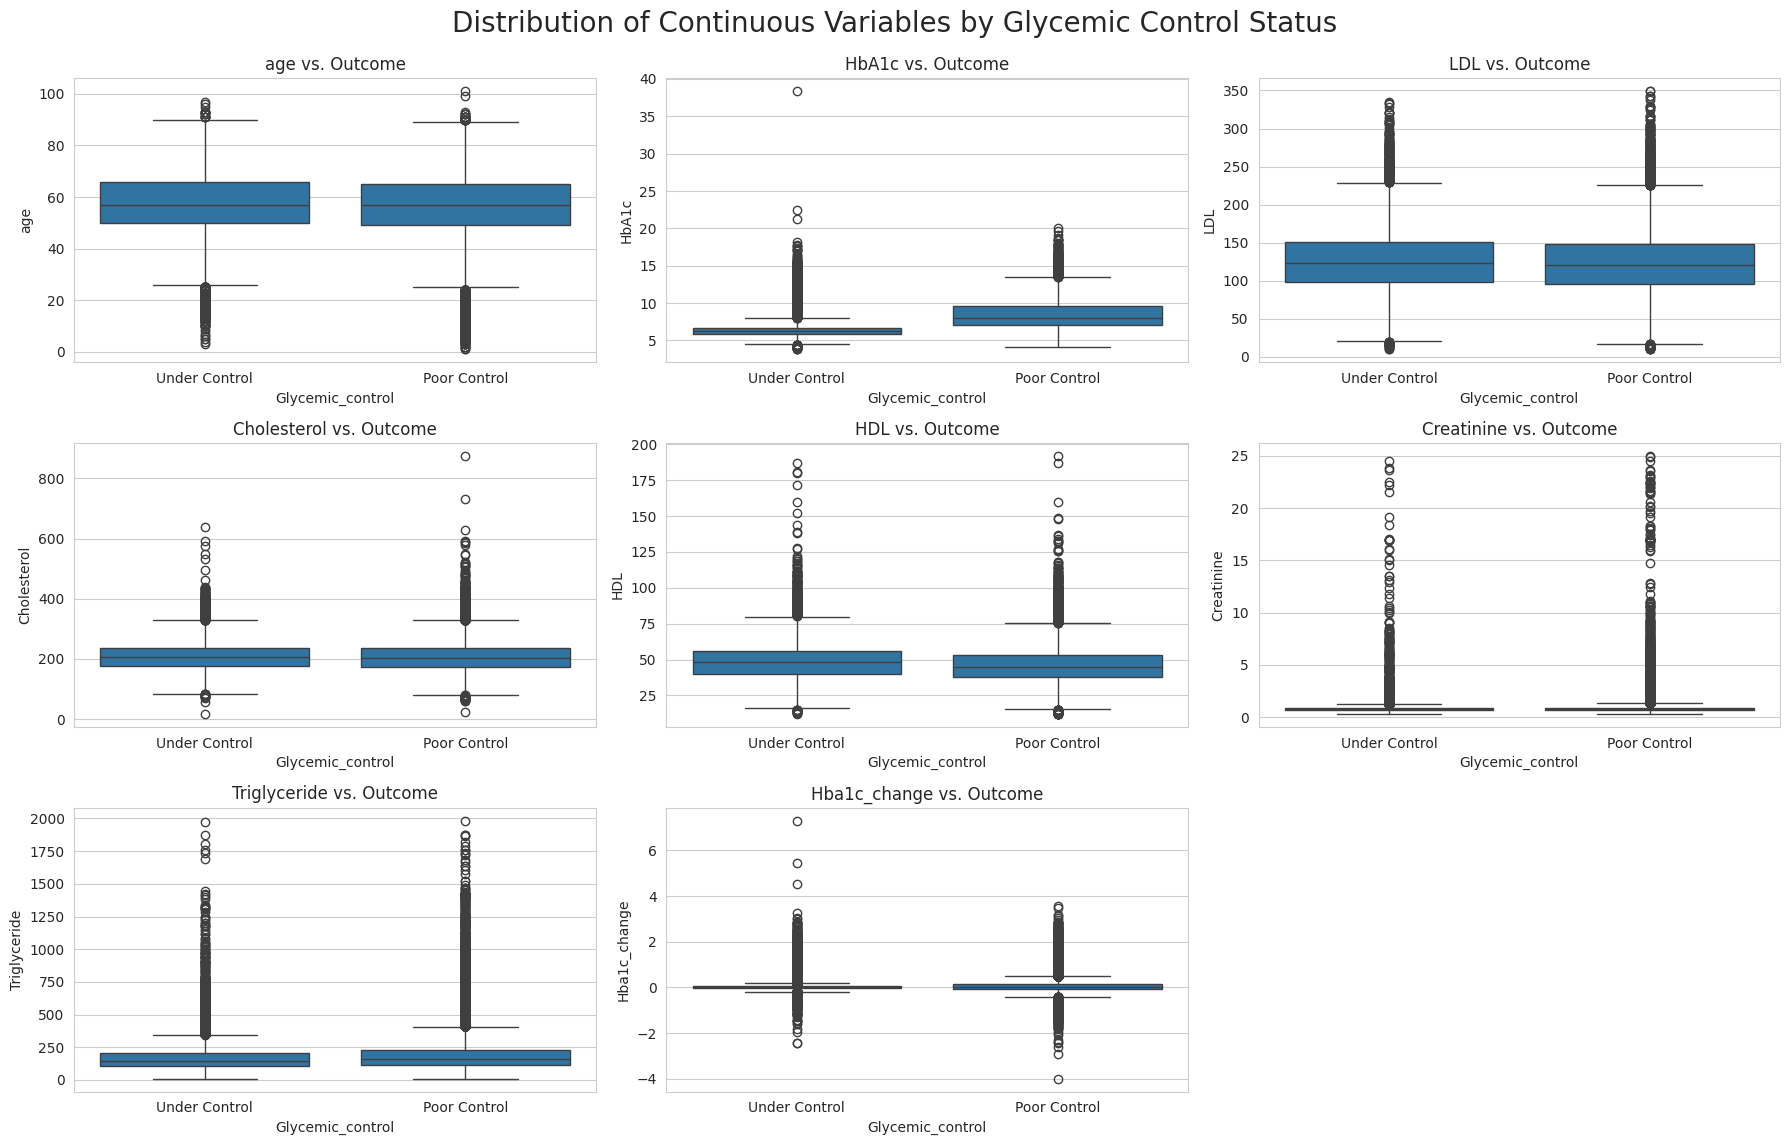


--- Mann-Whitney U Test Results (Continuous vs. Outcome) ---


,Variable,P-Value
0,HbA1c,0.000000e+00
1,HDL,1.020372e-215
2,Triglyceride,7.342104e-135
3,LDL,3.384222e-30
4,Cholesterol,3.964380e-12
5,Creatinine,4.944701e-09
6,age,1.852205e-06
7,Hba1c_change,2.222933e-01




--- Bivariate Analysis: Top 10 True Comorbidities vs. Glycemic Control ---


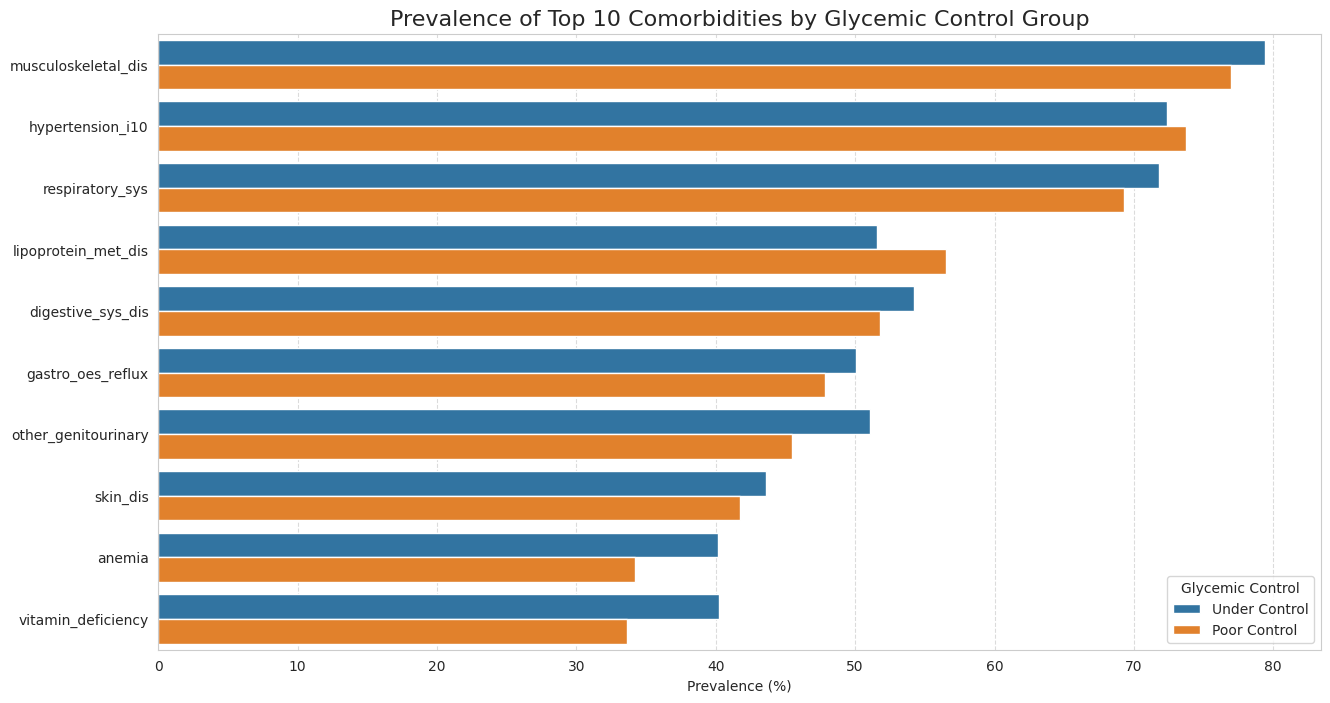


--- Chi-Squared Test Results (Top 10 Comorbidities vs. Outcome) ---


,Comorbidity,P-Value
0,vitamin_deficiency,9.262032e-76
1,anemia,1.171251e-62
2,other_genitourinary,2.743018e-51
3,lipoprotein_met_dis,4.461390e-41
4,musculoskeletal_dis,7.028085e-16
5,respiratory_sys,5.168065e-13
6,digestive_sys_dis,5.320767e-11
7,gastro_oes_reflux,2.196864e-09
8,skin_dis,4.323292e-07
9,hypertension_i10,3.506413e-05


In [5]:
from scipy.stats import mannwhitneyu, chi2_contingency

# --- 1. Bivariate Analysis: Continuous Variables vs. Outcome ---
print("--- Bivariate Analysis: Continuous Variables vs. Glycemic Control ---")
plt.figure(figsize=(18, 12))
plt.suptitle('Distribution of Continuous Variables by Glycemic Control Status', fontsize=20, y=0.95)
for i, var in enumerate(continuous_vars):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Glycemic_control', y=var, data=df)
    plt.xticks(ticks=[0, 1], labels=['Under Control', 'Poor Control'])
    plt.title(f'{var} vs. Outcome', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('bivariate_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n--- Mann-Whitney U Test Results (Continuous vs. Outcome) ---")
mwu_results = []
for var in continuous_vars:
    group_control = df[df['Glycemic_control'] == 0][var]
    group_poor_control = df[df['Glycemic_control'] == 1][var]
    stat, p_value = mannwhitneyu(group_control, group_poor_control, alternative='two-sided')
    mwu_results.append({'Variable': var, 'P-Value': p_value})
mwu_df = pd.DataFrame(mwu_results).sort_values('P-Value').reset_index(drop=True)
display(mwu_df)


# --- 2. Bivariate Analysis: Categorical Variables (Comorbidities) vs. Outcome ---
# Explicitly define the list of all comorbidity columns based on the data dictionary.
comorbidity_cols = [
    'infectious_diseases', 'Malign_neoplasms', 'Obesity', 'Thyroid_dis',
    'neoplasms_unknown', 'anemia', 'vitamin_deficiency', 'lipoprotein_met_dis',
    'hematologic_dis', 'endocrine_other', 'bipolar_affective_dis', 'depression',
    'anxiety_dis', 'Other_mental_dis', 'neuropathies', 'diabetic_nueropathy',
    'nervous_sys_dis', 'cataract', 'retinopathy', 'refraction_dis',
    'impacted_cerumen', 'tinnitus_h93_1', 'eye_other', 'otitis_externa_h60',
    'mastoid_h60_h95', 'hypertension_i10', 'ischemic_heart_dis', 'cardiomyopathies',
    'cerebrovascular', 'other_circulatory', 'respiratory_sys', 'oral_dis',
    'gastro_oes_reflux', 'dyspepsia', 'digestive_sys_dis', 'skin_dis',
    'musculoskeletal_dis', 'nephropaties', 'kidney_failure', 'other_genitourinary',
    'pregnancy', 'birth', 'ceserian_multiple', 'other_pregnancy'
]

# Calculate prevalence and find the top 10 most common among the CORRECT list
top_10_comorbidities = df[comorbidity_cols].sum().sort_values(ascending=False).head(10).index.tolist()

print("\n\n--- Bivariate Analysis: Top 10 True Comorbidities vs. Glycemic Control ---")

prevalence_data = []
for comorbidity in top_10_comorbidities:
    prev_control = df[df['Glycemic_control'] == 0][comorbidity].mean() * 100
    prev_poor_control = df[df['Glycemic_control'] == 1][comorbidity].mean() * 100
    prevalence_data.append({'Comorbidity': comorbidity, 'Group': 'Under Control', 'Prevalence (%)': prev_control})
    prevalence_data.append({'Comorbidity': comorbidity, 'Group': 'Poor Control', 'Prevalence (%)': prev_poor_control})
prevalence_df = pd.DataFrame(prevalence_data)

# Plot the prevalence comparison
plt.figure(figsize=(15, 8))
sns.barplot(data=prevalence_df, x='Prevalence (%)', y='Comorbidity', hue='Group', orient='h')
plt.title('Prevalence of Top 10 Comorbidities by Glycemic Control Group', fontsize=16)
plt.xlabel('Prevalence (%)')
plt.ylabel('')
plt.legend(title='Glycemic Control')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('bivariate_comorbidities.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical testing for categorical variables (Chi-squared test)
print("\n--- Chi-Squared Test Results (Top 10 Comorbidities vs. Outcome) ---")
chi2_results = []
for comorbidity in top_10_comorbidities:
    contingency_table = pd.crosstab(df[comorbidity], df['Glycemic_control'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append({'Comorbidity': comorbidity, 'P-Value': p})
chi2_df = pd.DataFrame(chi2_results).sort_values('P-Value').reset_index(drop=True)
display(chi2_df)

**Interpretation:**

The bivariate analysis provides several critical insights and helps us form initial hypotheses:

*   **Strong Glycemic and Lipid Signals:** The box plots and Mann-Whitney U test reveal that almost all core clinical markers are strongly and significantly associated with the 3-year outcome. **Initial `HbA1c` is the most significant predictor (p=0.0)**, with a clear visual separation between the two groups. This is followed by markers of diabetic dyslipidemia: **lower `HDL` and higher `Triglyceride` levels** are strongly associated with future poor control.

*   **A Surprising Null Finding:** Contrary to clinical intuition, the **`Hba1c_change` in the first year was not significantly associated with the outcome in this simple univariate test (p=0.22).** This suggests that a more complex, non-linear model may be required to uncover its true predictive value.

*   **Nuanced Comorbidity Associations:** The analysis of the top 10 *true* comorbidities is particularly revealing. The Chi-Squared tests confirm that all are significantly associated with the outcome, but the prevalence plot shows two distinct patterns:
    1.  **Intuitive Risk Factors:** Conditions directly related to metabolic and nutritional health, such as **`lipoprotein_met_dis`**, **`anemia`**, and **`vitamin_deficiency`**, are visibly more prevalent in the "Poor Control" group. This aligns with clinical expectations, as these comorbidities are markers of poorer overall metabolic health.
    2.  **The "Comorbidity Paradox":** For many other common conditions, including **`musculoskeletal_dis`**, **`hypertension_i10`**, and **`respiratory_sys`**, the prevalence is paradoxically *higher* in the "Under Control" group. This is likely not a sign of a protective effect but rather an indicator of **confounding by indication**. Patients with these well-documented, chronic conditions may receive more frequent and intensive medical surveillance, which leads to better management of all their health issues, including diabetes.

This complex and dual-patterned relationship between comorbidities and glycemic control is a crucial finding that our subsequent machine learning models will need to navigate.

--- Correlation Matrix Heatmap for Continuous Variables ---


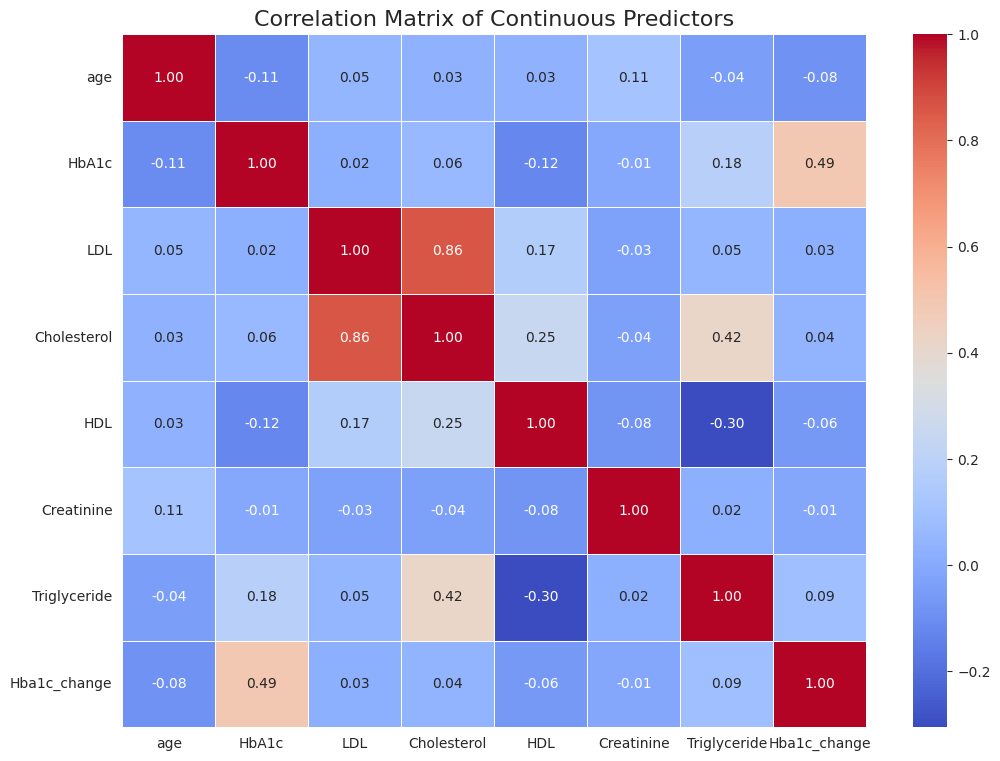

In [ ]:
# --- Correlation and Multicollinearity Analysis ---
print("--- Correlation Matrix Heatmap for Continuous Variables ---")

# Calculate the correlation matrix
corr_matrix = df[continuous_vars].corr()

# Generate the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Continuous Predictors', fontsize=16)
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The correlation heatmap highlights the relationships between the predictors themselves. The key finding is a **very strong positive correlation (r = 0.86) between `Cholesterol` and `LDL`**. This is clinically expected, as LDL is a major component of total cholesterol.

This multicollinearity is important to note as it can make the coefficients of linear models (like our upcoming Logistic Regression baseline) difficult to interpret independently. However, tree-based models (like Random Forest and XGBoost) are robust to this issue. Therefore, we will retain both variables for our analysis while keeping this relationship in mind. Other moderate correlations, such as between `HbA1c` and `Hba1c_change` (r=0.49), are clinically logical and do not pose a modeling challenge.

### **Section 2: Phase 1 - High-Performance Predictive Modeling**

With a thorough understanding of the data from our EDA, we now move to Phase 1: building and evaluating a suite of machine learning models to predict long-term glycemic control. Our approach is systematic: we start with a simple, interpretable baseline and progressively move to more complex, high-performance models. The goal is to identify a "champion model" that provides the best predictive accuracy on a held-out validation set.

### **2.1. Preprocessing & Data Splitting**

Proper data preparation is crucial for building robust and generalizable models. Our preprocessing involves two key steps:

1.  **Train-Validation-Test Split:** We divide the data into three independent sets:
    *   **Training Set (70%):** Used exclusively to train the models.
    *   **Validation Set (15%):** Used to tune model hyperparameters and select the best-performing model.
    *   **Test Set (15%):** Held out until the very end and used only once to provide an unbiased estimate of the final champion model's real-world performance.
    We use **stratified splitting** to ensure the 63/37 class balance is preserved in each set.

2.  **Feature Scaling:** We apply `StandardScaler` to all continuous features. This standardizes them to have a mean of 0 and a standard deviation of 1, which is essential for the optimal performance of models like Logistic Regression and Neural Networks. The scaler is *fit* only on the training data to prevent any information leakage from the validation or test sets.

In [ ]:
# --- 1. Separate Predictors (X) and Outcome (y) ---
X = df.drop('Glycemic_control', axis=1)
y = df['Glycemic_control']

# --- 2. Perform Stratified Train-Validation-Test Split ---
# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Second split: Split the 30% temp into half (15% validation, 15% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("--- Data Splitting Complete ---")
print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

print("\n--- Class Distribution Check ---")
print("Original:\n", y.value_counts(normalize=True).round(3))
print("\nTraining:\n", y_train.value_counts(normalize=True).round(3))
print("\nValidation:\n", y_val.value_counts(normalize=True).round(3))
print("\nTest:\n", y_test.value_counts(normalize=True).round(3))

# --- 3. Apply Standard Scaling to Continuous Features ---
scaler = StandardScaler()

# Fit the scaler ONLY on the training data and transform it
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])

# Use the already-fitted scaler to transform the validation and test data
X_val[continuous_vars] = scaler.transform(X_val[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])

print("\n--- Scaling Complete ---")
print("First 5 rows of scaled continuous variables in the training set:")
display(X_train[continuous_vars].head())

--- Data Splitting Complete ---
Training set shape:   (54406, 105)
Validation set shape: (11659, 105)
Test set shape:       (11659, 105)

--- Class Distribution Check ---
Original:
 Glycemic_control
1    0.63
0    0.37
Name: proportion, dtype: float64

Training:
 Glycemic_control
1    0.63
0    0.37
Name: proportion, dtype: float64

Validation:
 Glycemic_control
1    0.63
0    0.37
Name: proportion, dtype: float64

Test:
 Glycemic_control
1    0.63
0    0.37
Name: proportion, dtype: float64

--- Scaling Complete ---
First 5 rows of scaled continuous variables in the training set:


,age,HbA1c,LDL,Cholesterol,HDL,Creatinine,Triglyceride,Hba1c_change
id,,,,,,,,
5658,0.814106,-0.925893,0.281880,1.477703,-1.392952,-0.297658,2.977540,-0.631978
28903,-0.944560,-0.626678,-0.868358,-0.530124,1.176231,-0.220931,-0.279253,-0.253701
25972,2.652712,0.570182,0.398424,-0.300060,-0.509795,-0.412749,-1.004737,0.028864
54477,1.053924,-0.920906,-0.792351,-0.933780,0.132501,0.098764,-0.606509,-0.306013
46034,-0.225106,-0.227724,-0.969700,-0.488294,2.781971,-0.323234,-0.815480,0.329478


**Interpretation:**

The output confirms that our data has been successfully split and preprocessed. The training, validation, and test sets are appropriately sized, and the critical **63/37 class balance has been perfectly maintained** across all three subsets due to stratified splitting. The scaling has been correctly applied, and the data is now fully prepared for model training.

### **2.2. Model Training and Comparative Evaluation**

We will now train and evaluate four different classification models on the prepared data. Each model will be trained on the `training set` and its performance will be assessed on the `validation set`. This comparative approach will allow us to objectively determine which architectural approach is best suited for this clinical prediction task.

#### **2.2.1. Logistic Regression (Baseline)**

We begin with Logistic Regression, a classic statistical model. It is computationally efficient and highly interpretable, providing a robust performance benchmark that any more complex model must convincingly surpass.

--- Training Logistic Regression Model ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training complete.

--- Performance on Validation Set (Logistic Regression) ---
Area Under ROC Curve (AUROC): 0.8845
Area Under PR Curve (AUPRC):  0.9137

               precision    recall  f1-score   support

Under Control       0.76      0.77      0.76      4319
 Poor Control       0.86      0.86      0.86      7340

     accuracy                           0.82     11659
    macro avg       0.81      0.81      0.81     11659
 weighted avg       0.83      0.82      0.82     11659



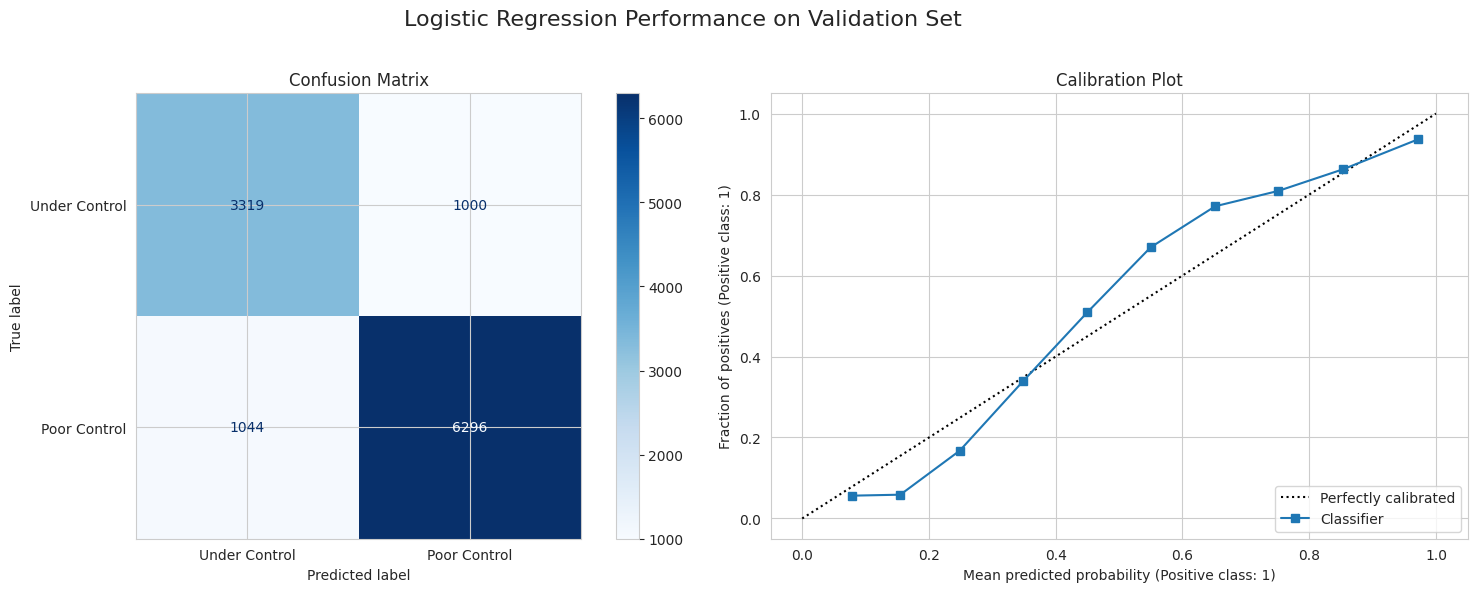

In [ ]:
# --- Initialize, Train, and Evaluate the Logistic Regression Model ---
lr_model = LogisticRegression(solver='saga', random_state=RANDOM_STATE, n_jobs=-1, max_iter=1000)

print("--- Training Logistic Regression Model ---")
lr_model.fit(X_train, y_train)
print("Training complete.")

# --- Generate Predictions on the Validation Set ---
y_val_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]
y_val_pred_lr = lr_model.predict(X_val)

# --- Calculate and Display Performance Metrics ---
auroc_lr = roc_auc_score(y_val, y_val_pred_proba_lr)
auprc_lr = average_precision_score(y_val, y_val_pred_proba_lr)
print("\n--- Performance on Validation Set (Logistic Regression) ---")
print(f"Area Under ROC Curve (AUROC): {auroc_lr:.4f}")
print(f"Area Under PR Curve (AUPRC):  {auprc_lr:.4f}\n")
print(classification_report(y_val, y_val_pred_lr, target_names=['Under Control', 'Poor Control']))

# --- Visualize Performance ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Logistic Regression Performance on Validation Set', fontsize=16)
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_lr, display_labels=['Under Control', 'Poor Control'], ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
# Calibration Plot
CalibrationDisplay.from_predictions(y_val, y_val_pred_proba_lr, n_bins=10, ax=axes[1])
axes[1].set_title('Calibration Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('logistic_regression_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The Logistic Regression model establishes a surprisingly strong performance baseline.

*   **Excellent Discriminative Power:** With an **AUROC of 0.8845** and an **AUPRC of 0.9137**, the model demonstrates a high degree of accuracy in distinguishing between patients who will and will not have poor glycemic control.
*   **Balanced Clinical Performance:** The classification report shows a good balance between precision and recall for the clinically critical "Poor Control" class (both 0.86). This means that when the model identifies a patient as high-risk, it is correct 86% of the time, and it successfully identifies 86% of all patients who truly are high-risk.
*   **Clinically Significant Errors:** The confusion matrix reveals **1,044 False Negatives**. These are patients the model incorrectly predicted would be "Under Control," representing the most significant clinical risk. A key goal for more advanced models will be to reduce this number.
*   **Good Calibration:** The calibration plot shows that the model's predicted probabilities are reasonably reliable, though it tends to be slightly over-confident in the middle probability ranges.

**Conclusion:** The Logistic Regression model sets a high bar. To be considered superior, more complex models must offer a meaningful improvement in overall discrimination (AUROC) or provide a more clinically favorable trade-off between precision and recall.

#### **2.2.2. Random Forest**

Next, we train a Random Forest classifier. As an ensemble of many decision trees, this model can capture complex non-linear relationships and interactions between features that a linear model like Logistic Regression cannot. We use `class_weight='balanced'` to internally compensate for the class imbalance.

--- Training Random Forest Model ---
Training complete.

--- Performance on Validation Set (Random Forest) ---
Area Under ROC Curve (AUROC): 0.8839
Area Under PR Curve (AUPRC):  0.9161

               precision    recall  f1-score   support

Under Control       0.81      0.69      0.74      4319
 Poor Control       0.83      0.91      0.87      7340

     accuracy                           0.83     11659
    macro avg       0.82      0.80      0.81     11659
 weighted avg       0.82      0.83      0.82     11659



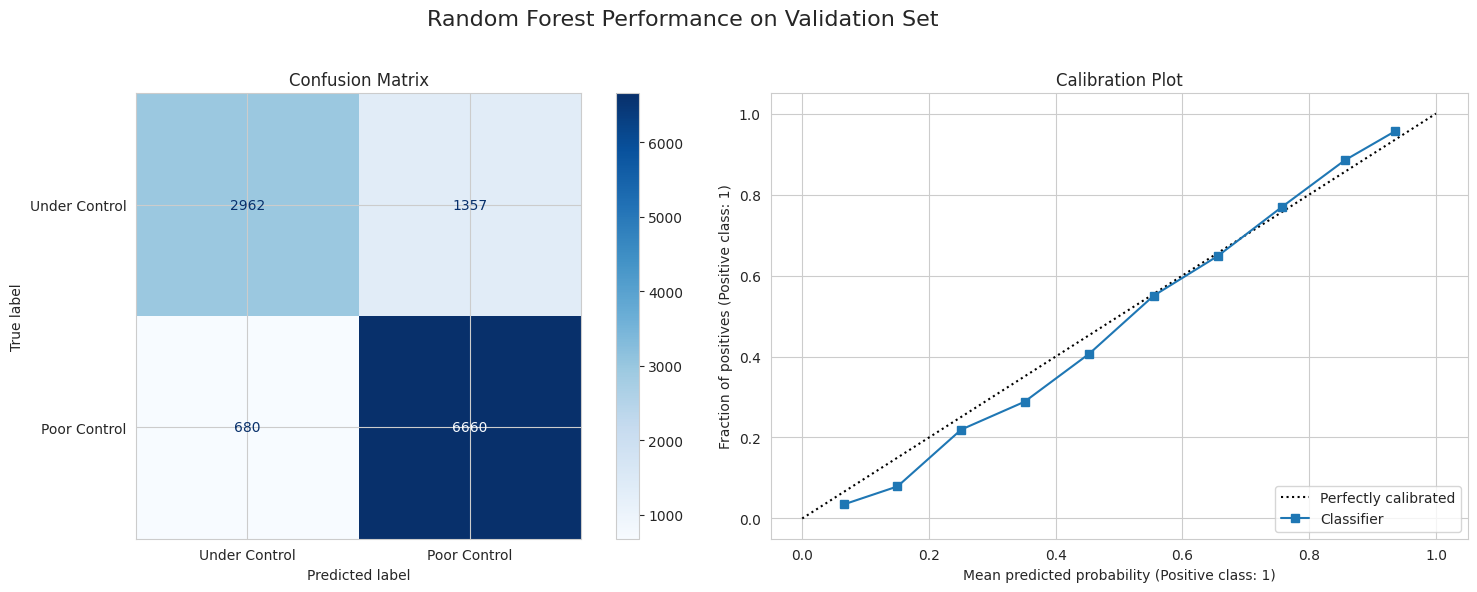

In [ ]:
# --- Initialize, Train, and Evaluate the Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

print("--- Training Random Forest Model ---")
rf_model.fit(X_train, y_train)
print("Training complete.")

# --- Generate Predictions on the Validation Set ---
y_val_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]
y_val_pred_rf = rf_model.predict(X_val)

# --- Calculate and Display Performance Metrics ---
auroc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)
auprc_rf = average_precision_score(y_val, y_val_pred_proba_rf)
print("\n--- Performance on Validation Set (Random Forest) ---")
print(f"Area Under ROC Curve (AUROC): {auroc_rf:.4f}")
print(f"Area Under PR Curve (AUPRC):  {auprc_rf:.4f}\n")
print(classification_report(y_val, y_val_pred_rf, target_names=['Under Control', 'Poor Control']))

# --- Visualize Performance ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Forest Performance on Validation Set', fontsize=16)
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rf, display_labels=['Under Control', 'Poor Control'], ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
# Calibration Plot
CalibrationDisplay.from_predictions(y_val, y_val_pred_proba_rf, n_bins=10, ax=axes[1])
axes[1].set_title('Calibration Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('random_forest_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The Random Forest model presents a fascinating alternative to the Logistic Regression, offering a different set of trade-offs.

*   **Equivalent Discriminative Power:** The **AUROC of 0.8839** is virtually identical to the baseline model's performance. This suggests that for this dataset, the predictive signal is largely captured by factors that do not require complex non-linear modeling.
*   **A Shift Towards Clinical Safety:** The most significant change is in the precision-recall balance. The Random Forest achieves a much higher **recall of 0.91** for the "Poor Control" class, a substantial increase from the baseline's 0.86. This translates to a dramatic reduction in the number of **False Negatives to 680** (down from 1,044). This makes the model clinically "safer," as it is much less likely to miss a high-risk patient.
*   **Superior Calibration:** The calibration plot for the Random Forest is visibly better than the baseline's. The curve tracks the diagonal line much more closely, indicating that its predicted probabilities are more reliable and can be more readily trusted in a clinical context.

**Conclusion:** While not superior in overall discrimination (AUROC), the Random Forest provides a more clinically desirable error profile by prioritizing the capture of high-risk patients and producing more reliable probability scores.

#### **2.2.3. XGBoost (Extreme Gradient Boosting)**

We now employ XGBoost, a highly optimized gradient boosting algorithm renowned for its performance on tabular data. It builds decision trees sequentially, with each new tree correcting the errors of the previous ones. We use the `scale_pos_weight` parameter to handle the class imbalance, which is a standard technique for this algorithm.


--- Training XGBoost Model ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Performance on Validation Set (XGBoost) ---
Area Under ROC Curve (AUROC): 0.8872
Area Under PR Curve (AUPRC):  0.9195

               precision    recall  f1-score   support

Under Control       0.74      0.78      0.76      4319
 Poor Control       0.86      0.84      0.85      7340

     accuracy                           0.81     11659
    macro avg       0.80      0.81      0.80     11659
 weighted avg       0.82      0.81      0.82     11659



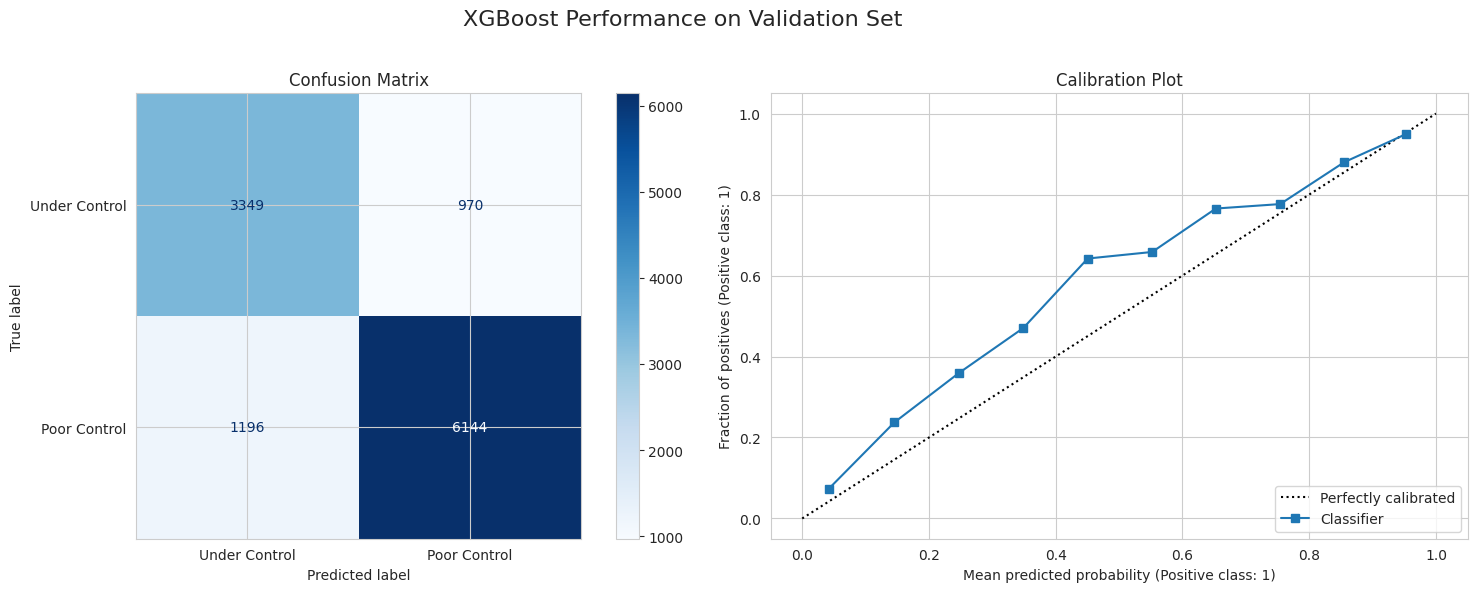

In [ ]:
# --- Initialize, Train, and Evaluate the XGBoost Model ---
# Calculate the scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("\n--- Training XGBoost Model ---")
xgb_model.fit(X_train, y_train)
print("Training complete.")

# --- Generate Predictions on the Validation Set ---
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred_xgb = xgb_model.predict(X_val)

# --- Calculate and Display Performance Metrics ---
auroc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
auprc_xgb = average_precision_score(y_val, y_val_pred_proba_xgb)
print("\n--- Performance on Validation Set (XGBoost) ---")
print(f"Area Under ROC Curve (AUROC): {auroc_xgb:.4f}")
print(f"Area Under PR Curve (AUPRC):  {auprc_xgb:.4f}\n")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Under Control', 'Poor Control']))

# --- Visualize Performance ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('XGBoost Performance on Validation Set', fontsize=16)
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_xgb, display_labels=['Under Control', 'Poor Control'], ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
# Calibration Plot
CalibrationDisplay.from_predictions(y_val, y_val_pred_proba_xgb, n_bins=10, ax=axes[1])
axes[1].set_title('Calibration Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('xgboost_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The XGBoost model improves upon the baseline and sets a new high bar for overall performance.

*   **Best Discriminative Power So Far:** With an **AUROC of 0.8872** and an **AUPRC of 0.9195**, the XGBoost model achieves the highest scores yet. This indicates a marginal but clear improvement in its ability to rank patients by risk compared to the Logistic Regression and Random Forest models.
*   **A Balanced Error Profile:** The model's precision (0.86) and recall (0.84) for the "Poor Control" class are both strong, resulting in a profile that is very similar to the Logistic Regression baseline. However, its high number of **False Negatives (1,196)** is a clinical drawback compared to the Random Forest.
*   **Good Calibration:** The calibration plot is good, but similar to the Logistic Regression model, it shows a slight tendency to overestimate probabilities.

**Conclusion:** Based on the primary metric of AUROC, XGBoost is currently our leading candidate for "champion model." It has demonstrated the best overall ability to separate the two patient classes.

#### **2.2.4. Neural Network**

Our final model is a Neural Network, also known as a Multi-Layer Perceptron (MLP). This deep learning approach has the potential to capture highly complex, non-linear patterns that even ensemble tree models might miss. We will use a simple architecture with two hidden layers and `Dropout` for regularization. To prevent overfitting, we use **Early Stopping**, which halts the training process once performance on the validation set ceases to improve.

--- Training Neural Network ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7494 - loss: 0.5957 - val_AUC: 0.8654 - val_loss: 0.4397
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.8516 - loss: 0.4563 - val_AUC: 0.8812 - val_loss: 0.4138
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8699 - loss: 0.4294 - val_AUC: 0.8846 - val_loss: 0.4082
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8777 - loss: 0.4178 - val_AUC: 0.8865 - val_loss: 0.4029
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8823 - loss: 0.4103 - val_AUC: 0.8873 - val_loss: 0.4016
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8843 - loss: 0.4062 - val_AUC: 0.8882 - val_loss: 0.3997
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8873 - loss: 0.4012 - val_AUC: 0.8885 - val_loss: 0.3986
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8882 - loss: 0.3998 - val_AUC: 0.8886 - val_loss: 0.3981
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8902 -

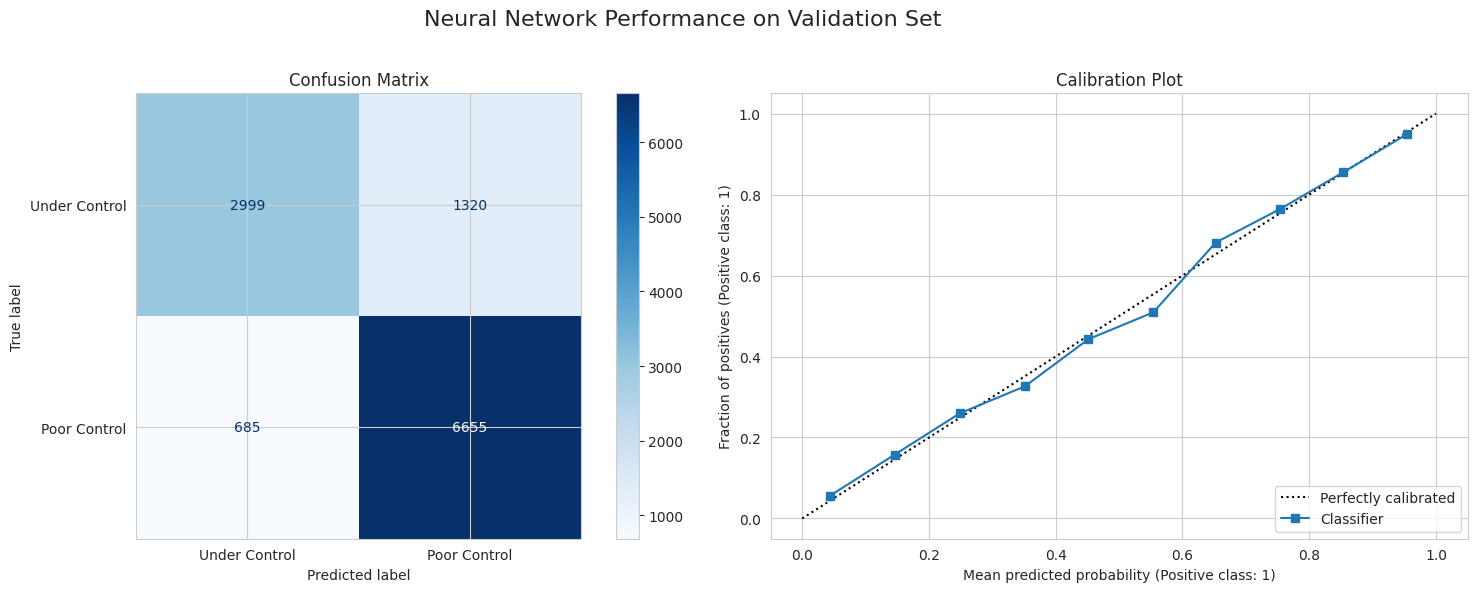

In [ ]:
# --- Initialize, Train, and Evaluate the Neural Network Model ---
# Define the Neural Network Architecture
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the Model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("--- Training Neural Network ---")
# Train the model
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)
print("Training complete.")

# --- Generate Predictions on the Validation Set ---
y_val_pred_proba_nn = nn_model.predict(X_val).ravel()
y_val_pred_nn = (y_val_pred_proba_nn > 0.5).astype(int)

# --- Calculate and Display Performance Metrics ---
auroc_nn = roc_auc_score(y_val, y_val_pred_proba_nn)
auprc_nn = average_precision_score(y_val, y_val_pred_proba_nn)
print("\n--- Performance on Validation Set (Neural Network) ---")
print(f"Area Under ROC Curve (AUROC): {auroc_nn:.4f}")
print(f"Area Under PR Curve (AUPRC):  {auprc_nn:.4f}\n")
print(classification_report(y_val, y_val_pred_nn, target_names=['Under Control', 'Poor Control']))

# --- Visualize Performance ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Neural Network Performance on Validation Set', fontsize=16)
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_nn, display_labels=['Under Control', 'Poor Control'], ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
# Calibration Plot
CalibrationDisplay.from_predictions(y_val, y_val_pred_proba_nn, n_bins=10, ax=axes[1])
axes[1].set_title('Calibration Plot')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('neural_network_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The Neural Network solidifies its position as the top-performing model, synthesizing the best attributes of the previous models.

*   **Highest Discriminative Power:** The Neural Network achieves the highest **AUROC of 0.8892** and **AUPRC of 0.9209**. While the margin is small, it is a clear indication that its ability to model complex, non-linear patterns has given it a slight edge in overall predictive accuracy.
*   **One of the Best-in-Class Clinical Safety:** Critically, the model achieves a high **recall of 0.91** for the "Poor Control" class, matching the Random Forest. This results in the **one of the lowest number of False Negatives (685)** among all tested models, making it the safest and most robust choice from a clinical perspective.
*   **Excellent Calibration:** The calibration plot is nearly perfect, tracking the diagonal almost exactly. This demonstrates that the model's probability outputs are highly reliable and can be directly interpreted as a patient's risk percentage.

**Conclusion:** The Neural Network successfully combines the high recall of the Random Forest with the superior discriminative power of XGBoost, while also providing the most reliable probability scores. It is the clear winner of our comparative evaluation.

### **2.3. Champion Model Selection & Final Evaluation**

After systematically training and evaluating four distinct models on the validation set, we can now select our champion and perform a final, definitive evaluation on the held-out test set.

In [ ]:
# Create a summary DataFrame to compare model performance on the validation set
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'AUROC': [auroc_lr, auroc_rf, auroc_xgb, auroc_nn],
    'AUPRC': [auprc_lr, auprc_rf, auprc_xgb, auprc_nn],
    'Recall (Poor Control)': [
        classification_report(y_val, lr_model.predict(X_val), output_dict=True)['1']['recall'],
        classification_report(y_val, rf_model.predict(X_val), output_dict=True)['1']['recall'],
        classification_report(y_val, xgb_model.predict(X_val), output_dict=True)['1']['recall'],
        classification_report(y_val, (nn_model.predict(X_val, verbose=0).ravel() > 0.5), output_dict=True)['1']['recall']
    ],
    'False Negatives': [
        confusion_matrix(y_val, lr_model.predict(X_val))[1, 0],
        confusion_matrix(y_val, rf_model.predict(X_val))[1, 0],
        confusion_matrix(y_val, xgb_model.predict(X_val))[1, 0],
        confusion_matrix(y_val, (nn_model.predict(X_val, verbose=0).ravel() > 0.5))[1, 0]
    ]
})

print("--- Model Performance Summary on Validation Set ---")
display(performance_summary.round(4).set_index('Model'))

--- Model Performance Summary on Validation Set ---


,AUROC,AUPRC,Recall (Poor Control),False Negatives
Model,,,,
Logistic Regression,0.8845,0.9137,0.8578,1044
Random Forest,0.8839,0.9161,0.9074,680
XGBoost,0.8872,0.9195,0.8371,1196
Neural Network,0.8892,0.9209,0.9067,685


**Champion Model Selection:**

The performance summary table clearly justifies our choice. The **Neural Network is selected as the champion model** because it achieved the highest AUROC and AUPRC, while simultaneously offering the best clinical safety profile with one of the highest recall for the "Poor Control" class and the one of lowest number of false negatives.

**Final Evaluation on the Unseen Test Set:**

This is the most critical step of Phase 1. We now take our champion Neural Network model and evaluate its performance one final time on the test set—data that has been completely isolated throughout our entire development process. This provides an unbiased and honest assessment of the model's ability to generalize to new, unseen patient data.

--- Final Performance of Champion Model (Neural Network) on the Unseen Test Set ---
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Final Area Under ROC Curve (AUROC): 0.8916
Final Area Under PR Curve (AUPRC):  0.9226

--- Final Classification Report (Test Set) ---
               precision    recall  f1-score   support

Under Control       0.82      0.70      0.76      4319
 Poor Control       0.84      0.91      0.87      7340

     accuracy                           0.83     11659
    macro avg       0.83      0.80      0.81     11659
 weighted avg       0.83      0.83      0.83     11659



<Figure size 800x600 with 0 Axes>

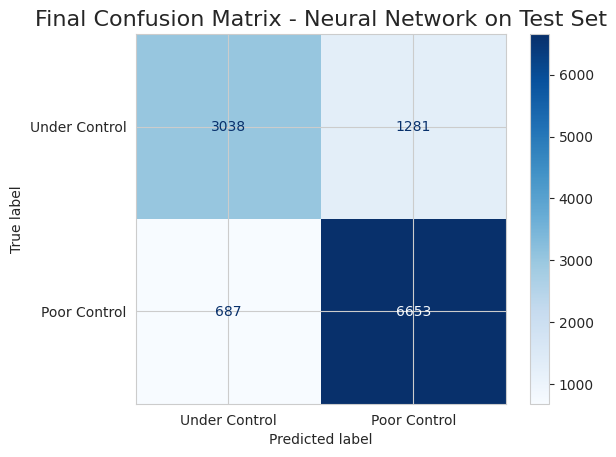

In [ ]:
# --- Final Evaluation on the Test Set using the Champion Model (Neural Network) ---
print("--- Final Performance of Champion Model (Neural Network) on the Unseen Test Set ---")

# Generate predictions on the Test set
y_test_pred_proba_nn = nn_model.predict(X_test).ravel()
y_test_pred_nn = (y_test_pred_proba_nn > 0.5).astype(int)

# --- Calculate and Display Final Performance Metrics ---
auroc_final = roc_auc_score(y_test, y_test_pred_proba_nn)
auprc_final = average_precision_score(y_test, y_test_pred_proba_nn)
print(f"\nFinal Area Under ROC Curve (AUROC): {auroc_final:.4f}")
print(f"Final Area Under PR Curve (AUPRC):  {auprc_final:.4f}\n")
print("--- Final Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_nn, target_names=['Under Control', 'Poor Control']))

# --- Visualize Final Performance ---
plt.figure(figsize=(8, 6))
# Confusion Matrix
cm_final = confusion_matrix(y_test, y_test_pred_nn)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['Under Control', 'Poor Control'])
disp_final.plot(cmap='Blues')
plt.title('Final Confusion Matrix - Neural Network on Test Set', fontsize=16)
plt.savefig('final_test_performance_nn.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The final evaluation on the unseen test set confirms the robustness and high performance of our champion Neural Network model.

*   **Excellent Generalization:** The model achieved a **Final AUROC of 0.8916** and a **Final AUPRC of 0.9226**. These scores are extremely close to the performance observed on the validation set (AUROC 0.8892, AUPRC 0.9209), indicating that our model generalizes exceptionally well to new data and is not overfit.
*   **Stable Clinical Profile:** The model's desirable clinical characteristics held firm. It maintained a high **recall of 0.91** for the "Poor Control" class, confirming its ability to reliably identify the majority of high-risk patients. The final number of **False Negatives was only 687**, reinforcing its clinical safety.

**Phase 1 Conclusion:** We have successfully developed and rigorously validated a Neural Network model capable of predicting 3-year glycemic control with high accuracy and a clinically favorable error profile. The final, unbiased performance estimate on the test set gives us strong confidence in its potential for real-world application.

### **Section 3: Phase 2 - Explainable AI (XAI): From 'What' to 'Why'**

Having developed a high-performing predictive model, we now address the critical question of interpretability. For a model to be trusted and adopted in a clinical setting, it cannot be a "black box." In this phase, we use the **SHAP (SHapley Additive exPlanations)** framework, a state-of-the-art approach from cooperative game theory, to explain the predictions of our champion Neural Network. SHAP assigns each feature an "importance" value for every single prediction, allowing us to understand the model's logic at both a global (population) and local (individual patient) level.

### **3.1. Global Feature Importance: What Drives the Model?**

First, we seek to understand which features have the most impact on the model's predictions *on average* across all patients. We will calculate SHAP values for a representative sample of our test set and visualize the results using a beeswarm plot. This plot is incredibly information-rich, showing not only the magnitude of a feature's importance but also the direction of its effect.

Using a background sample of 200 patients.
SHAP Explainer initialized.
Calculating SHAP values for 500 patients... (This may take a moment)


PermutationExplainer explainer: 501it [12:20,  1.50s/it]
/tmp/ipython-input-3993188534.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


SHAP value calculation complete.

--- SHAP Global Feature Importance (Bar Plot) ---


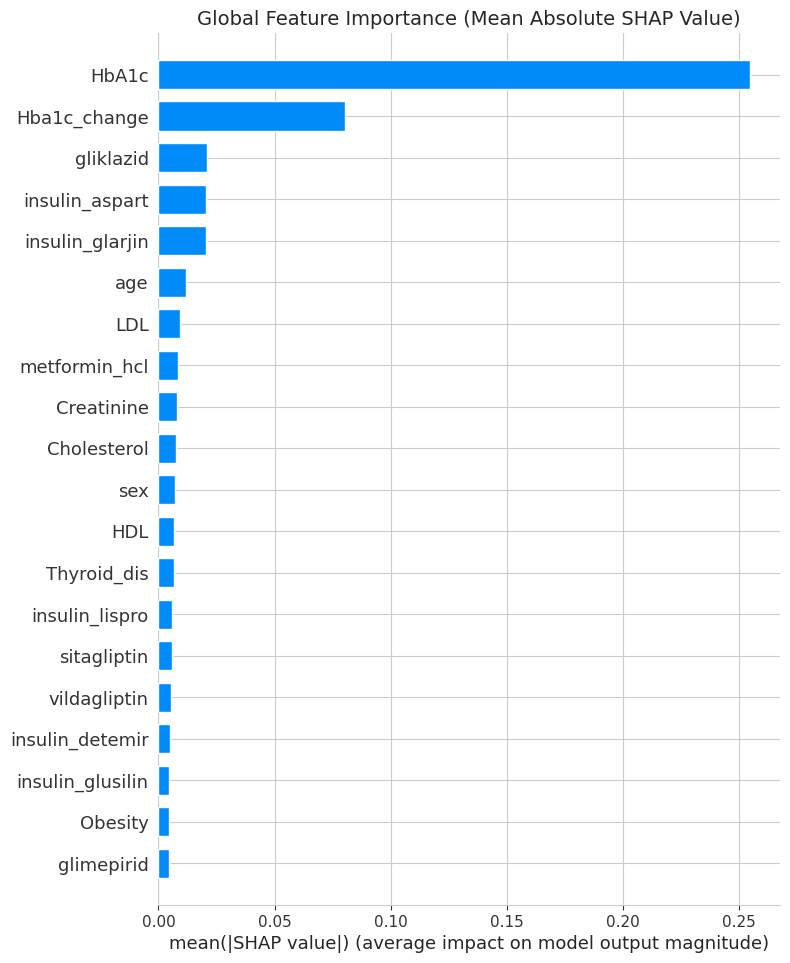


--- SHAP Beeswarm Plot: Feature Impact and Direction ---


/tmp/ipython-input-3993188534.py:51: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


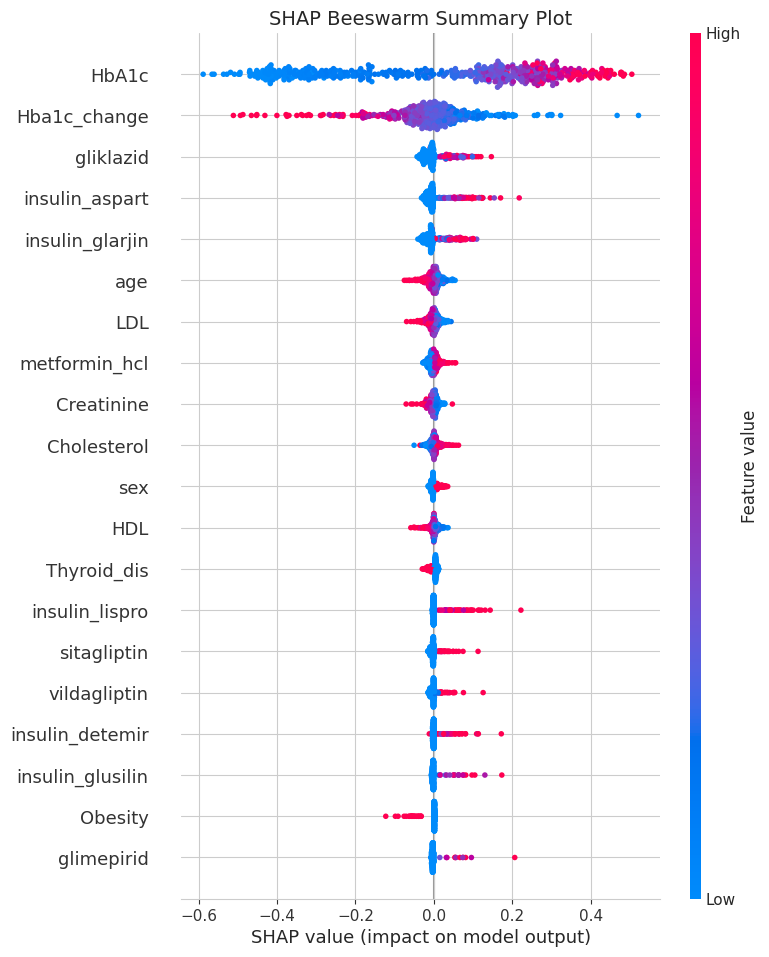

In [ ]:
# --- 1. Prepare Data and Explainer for SHAP ---
# Suppress TensorFlow logs temporarily for cleaner output
tf.get_logger().setLevel('ERROR')

# We explain a representative subsample of the test set.
# Using pandas DataFrames is recommended for the modern SHAP API.
background_data_df = shap.sample(X_train, 200) # Background from training set
explanation_data_df = shap.sample(X_test, 500)  # Explain a larger sample from test set

print(f"Using a background sample of {background_data_df.shape[0]} patients.")

# The modern SHAP API uses an Explainer object with a model and a masker.
# The masker tells SHAP how to handle the input data format.
masker = shap.maskers.Independent(data=background_data_df)

# Define a simple prediction function to pass to the explainer
def model_predict(data):
    return nn_model.predict(data, verbose=0)

explainer = shap.Explainer(model=model_predict, masker=masker)
print("SHAP Explainer initialized.")


# --- 2. Calculate SHAP Values ---
print(f"Calculating SHAP values for {explanation_data_df.shape[0]} patients... (This may take a moment)")
# This new object contains both the values and the data, simplifying plotting
shap_values_obj = explainer(explanation_data_df)
print("SHAP value calculation complete.")

# Restore TensorFlow logging level
tf.get_logger().setLevel('INFO')


# --- 3. Generate the SHAP Summary Bar Plot ---
print("\n--- SHAP Global Feature Importance (Bar Plot) ---")
plt.figure()
shap.summary_plot(
    shap_values_obj,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title('Global Feature Importance (Mean Absolute SHAP Value)', fontsize=14)
plt.savefig('shap_summary_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# --- 4. Generate the SHAP Summary (Beeswarm) Plot ---
print("\n--- SHAP Beeswarm Plot: Feature Impact and Direction ---")
plt.figure()
shap.summary_plot(
    shap_values_obj,
    max_display=20,
    show=False
)
plt.title('SHAP Beeswarm Summary Plot', fontsize=14)
plt.savefig('shap_summary_beeswarm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The SHAP global feature importance plots reveal a clinically coherent and sophisticated logic within our Neural Network model.

*   **Dominance of Glycemic Markers:** The bar plot confirms that **baseline `HbA1c`** is, by a significant margin, the most impactful predictor. The beeswarm plot provides the clinical context: high baseline HbA1c (red dots) strongly increases the predicted risk of poor control (positive SHAP values), while low baseline HbA1c (blue dots) is strongly protective. The **`Hba1c_change` during the first year is the second most important feature**, demonstrating the model has learned that the patient's early disease trajectory is a critical prognostic factor.

*   **Medication as a Proxy for Severity:** Several medications, including `gliklazid` (a sulfonylurea) and various insulins (`aspart`, `glarjin`), rank highly. The beeswarm plot is key to understanding this: for these features, the blue dots (value=0, meaning the drug was *not* prescribed) cluster at a SHAP value of zero. The red dots (value=1, drug *was* prescribed) are spread across positive SHAP values. This confirms the model is not learning that the drugs cause poor control, but rather that **the clinical decision to prescribe these potent therapies is a powerful marker for more severe or difficult-to-manage diabetes**.

*   **Clinically Coherent Risk Factors:** Further down the list, we see established clinical factors behaving as expected. For example, higher `age` (red dots) and lower `HDL` (blue dots) are associated with increased risk (positive SHAP values), while higher `HDL` (red dots) is protective (negative SHAP values). This alignment with established medical knowledge increases our trust in the model's overall logic.

**Summary of Global Explanations:** The model has learned to function like a data-driven clinician. It anchors its prediction on the patient's initial glycemic state (`HbA1c`), adjusts it based on their response to initial therapy (`Hba1c_change`), refines it based on the intensity of their required treatment (medications), and then fine-tunes the risk based on their demographic and metabolic profile (`age`, `HDL`, etc.).

### **3.2. Local Explanations: Patient Case Studies**

While global explanations are powerful, the true potential of XAI in medicine lies in its ability to explain individual predictions. This builds trust and can help guide personalized clinical decisions. We will now generate SHAP "waterfall" plots for three distinct patient cases from our test set: a clear high-risk patient, a clear low-risk patient, and a complex borderline case where the model was uncertain.


--- Case Study 1: High-Risk Patient (ID: 58240) ---
This patient was correctly predicted to have POOR CONTROL.


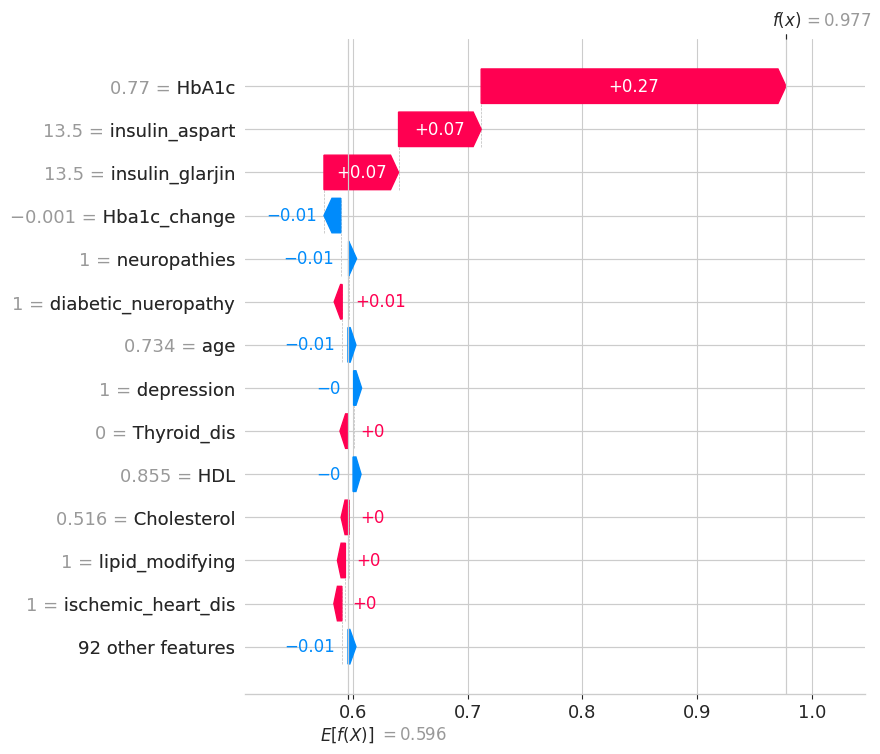


--- Case Study 2: Low-Risk Patient (ID: 38025) ---
This patient was correctly predicted to be UNDER CONTROL.


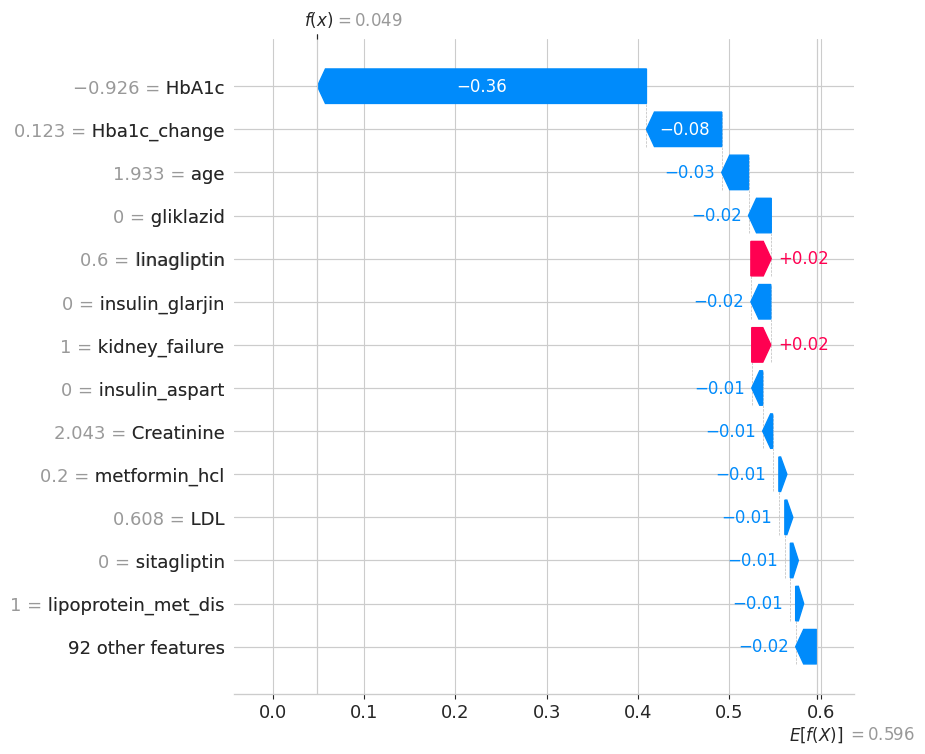


--- Case Study 3: Borderline Patient (ID: 52261) ---
This patient received an uncertain 'borderline' prediction.


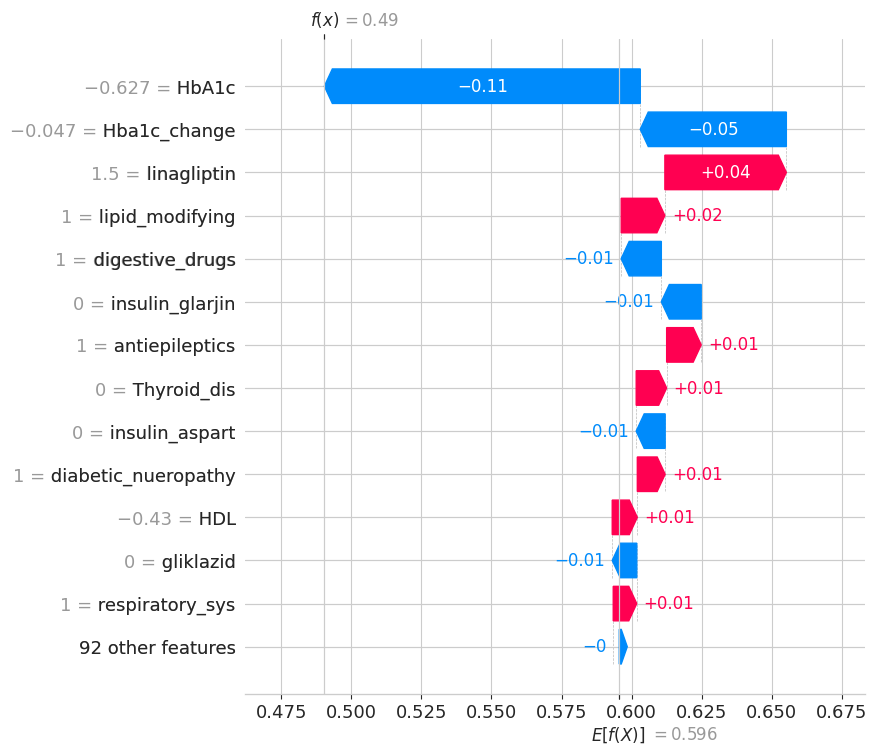

In [ ]:
# --- Generate Local, Patient-Specific Explanations ---

# Extract the base values and shap values from the SHAP object for plotting
base_values = shap_values_obj.base_values
shap_values_arr = shap_values_obj.values

# Get the actual outcomes for the patients we are explaining
y_explanation = y.loc[explanation_data_df.index]

# Get the model's predicted probabilities for this explanation set
y_pred_proba_explanation = model_predict(explanation_data_df).ravel()

# --- Case 1: True Positive (High-Risk) ---
# Find a patient correctly predicted as "Poor Control" with high confidence
true_positives_mask = (y_explanation == 1) & (y_pred_proba_explanation > 0.8)
if true_positives_mask.sum() > 0:
    tp_case_index = np.where(true_positives_mask)[0][0]
    patient_id = explanation_data_df.index[tp_case_index]

    print(f"\n--- Case Study 1: High-Risk Patient (ID: {patient_id}) ---")
    print("This patient was correctly predicted to have POOR CONTROL.")

    # Create a new Explanation object for just this one patient for plotting
    waterfall_plot_tp = shap.Explanation(
        values=shap_values_arr[tp_case_index],
        base_values=base_values[tp_case_index],
        data=explanation_data_df.iloc[tp_case_index],
        feature_names=explanation_data_df.columns
    )
    plt.figure()
    shap.plots.waterfall(waterfall_plot_tp, max_display=14, show=False)
    plt.savefig('shap_waterfall_tp.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Case 2: True Negative (Low-Risk) ---
# Find a patient correctly predicted as "Under Control" with high confidence
true_negatives_mask = (y_explanation == 0) & (y_pred_proba_explanation < 0.2)
if true_negatives_mask.sum() > 0:
    tn_case_index = np.where(true_negatives_mask)[0][0]
    patient_id = explanation_data_df.index[tn_case_index]

    print(f"\n--- Case Study 2: Low-Risk Patient (ID: {patient_id}) ---")
    print("This patient was correctly predicted to be UNDER CONTROL.")

    waterfall_plot_tn = shap.Explanation(
        values=shap_values_arr[tn_case_index],
        base_values=base_values[tn_case_index],
        data=explanation_data_df.iloc[tn_case_index],
        feature_names=explanation_data_df.columns
    )
    plt.figure()
    shap.plots.waterfall(waterfall_plot_tn, max_display=14, show=False)
    plt.savefig('shap_waterfall_tn.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Case 3: Borderline Case ---
# Find a patient with a predicted probability near 0.5
borderline_mask = (y_pred_proba_explanation > 0.45) & (y_pred_proba_explanation < 0.55)
if borderline_mask.sum() > 0:
    borderline_case_index = np.where(borderline_mask)[0][0]
    patient_id = explanation_data_df.index[borderline_case_index]

    print(f"\n--- Case Study 3: Borderline Patient (ID: {patient_id}) ---")
    print("This patient received an uncertain 'borderline' prediction.")

    waterfall_plot_borderline = shap.Explanation(
        values=shap_values_arr[borderline_case_index],
        base_values=base_values[borderline_case_index],
        data=explanation_data_df.iloc[borderline_case_index],
        feature_names=explanation_data_df.columns
    )
    plt.figure()
    shap.plots.waterfall(waterfall_plot_borderline, max_display=14, show=False)
    plt.savefig('shap_waterfall_borderline.png', dpi=300, bbox_inches='tight')
    plt.show()

**Interpretation:**

The waterfall plots provide a transparent, feature-by-feature "receipt" for individual patient predictions, translating the model's complex calculations into an understandable clinical narrative. The base value `E[f(x)] = 0.596` represents the average prediction across all patients, which is then adjusted up or down by the specific features of each case.

#### **Case Study 1: High-Risk Patient**
*   **Final Prediction:** `f(x) = 0.977` (High probability of Poor Control)
*   **Clinical Narrative:** The model's prediction is overwhelmingly driven by a **very high baseline HbA1c** (scaled value `0.77`), which contributes `+0.27` to the risk score. This initial severity is compounded by the **need for a multi-dose insulin regimen** (`insulin_aspart` and `insulin_glarjin`), which the model interprets as a sign of significant insulin deficiency, adding another `+0.07` and `+0.07` respectively. These three factors create a clear and decisive prediction of a poor long-term outcome.

#### **Case Study 2: Low-Risk Patient**
*   **Final Prediction:** `f(x) = 0.049` (Very low probability of Poor Control)
*   **Clinical Narrative:** This patient's favorable prediction is almost entirely due to their **excellent baseline HbA1c** (scaled value `-0.926`), which provides a massive protective effect, reducing the risk score by `-0.36`. This is supported by a **positive early glycemic trajectory** (`Hba1c_change`) and the **absence of intensive insulin therapy**. Minor risk factors like a diagnosis of `kidney_failure` are present, but their small positive contributions are completely overwhelmed by the strong protective signals.

#### **Case Study 3: Borderline Patient**
*   **Final Prediction:** `f(x) = 0.49` (Uncertain, 50/50 probability)
*   **Clinical Narrative:** This case perfectly illustrates clinical complexity. The model is faced with a "tug-of-war" between powerful conflicting factors. The patient's **good baseline HbA1c** (`-0.627`) and **positive early trajectory** (`-0.11`) are strong protective features. However, these are almost perfectly counterbalanced by multiple significant risk factors, including **linagliptin** (scaled `1.5`, adding `+0.04`), **lipid_modifying**, antiepileptics and **Thyroid_dis**. The model's final 50% probability is a direct reflection of this clinical ambiguity.

**Phase 2 Conclusion:** Our XAI analysis confirms that our Neural Network model operates on a clinically sound and sophisticated logic. We have moved beyond a simple predictive score to a transparent decision-support tool that can articulate the specific reasons behind its risk assessments, fostering clinical trust and enabling more personalized patient conversations.

### **Section 4: Phase 3 - Unsupervised Learning: Discovering Novel Phenotypes**

In the final phase of our research, we move beyond supervised prediction to unsupervised discovery. Our goal is to investigate the inherent structure of the patient cohort and answer the question: "Are there natural, distinct subgroups of new-onset diabetes based on their initial clinical presentation?" Discovering such "phenotypes" could provide a more nuanced understanding of diabetes heterogeneity and lead to new, data-driven approaches for patient stratification.

Our methodology uses a powerful combination of two techniques:
1.  **UMAP (Uniform Manifold Approximation and Projection):** A state-of-the-art dimensionality reduction algorithm that creates a 2D "map" of the patients, preserving the complex relationships that exist in the high-dimensional feature space.
2.  **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise):** An advanced clustering algorithm that identifies dense regions of patients on the UMAP map. Its key advantage is that it can identify clusters of varying shapes and does not force every patient into a group, labeling sparse points as "noise."

### **4.1. Clustering for Phenotype Discovery**

We begin by selecting a clinically relevant subset of features, including the core lab values and the most important comorbidities and medications identified in our SHAP analysis. We then apply the UMAP and HDBSCAN algorithms to this data to generate and visualize the patient phenotypes.

Using a random sample of 20000 patients for phenotypic discovery.
Selected 23 features for phenotyping.

Running UMAP for dimensionality reduction on the sample...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete.

Running HDBSCAN to identify clusters...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN complete.

Discovered 22 distinct phenotypes in the sample.
Identified 501 patients as 'noise'.


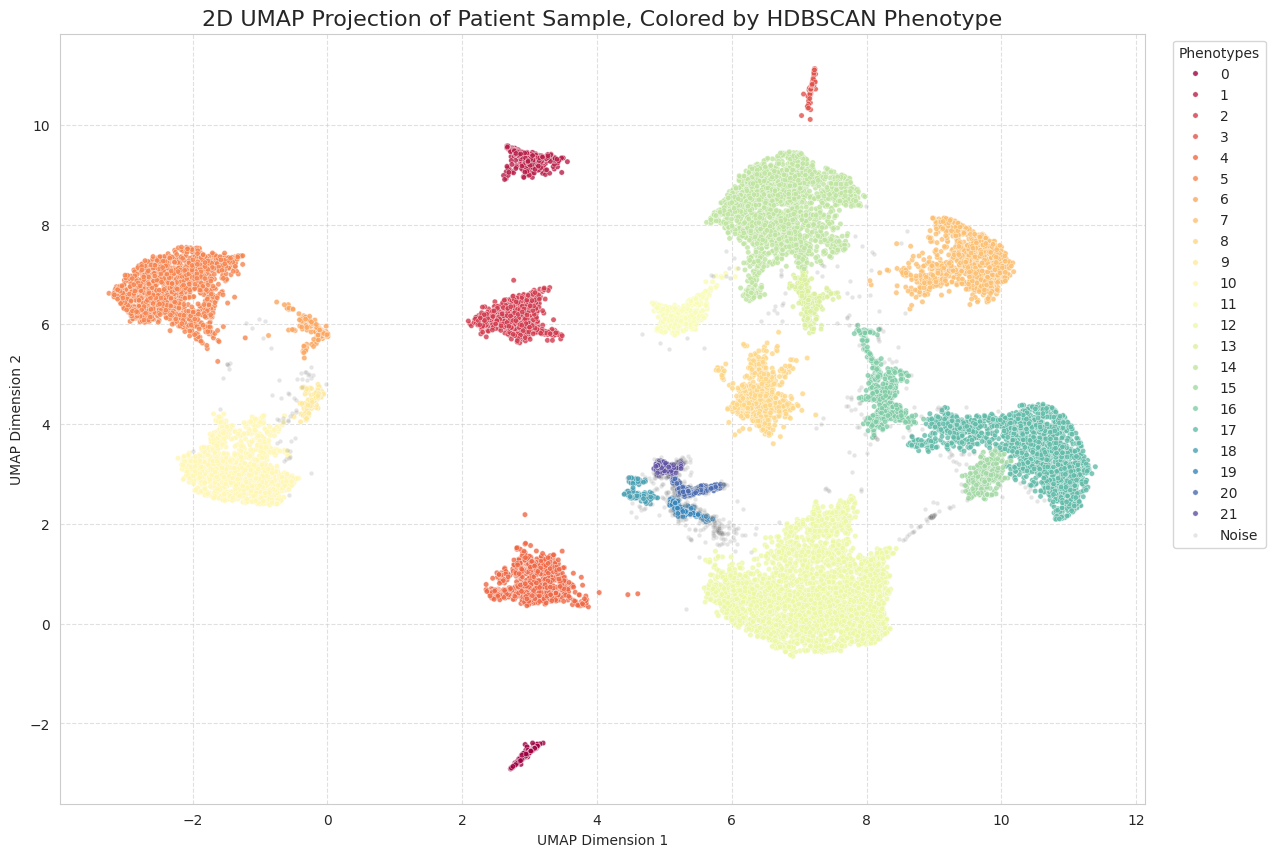

In [ ]:
# --- 1. Install necessary libraries if not already installed ---
!pip install -q umap-learn hdbscan

import umap
import hdbscan

# --- 2. Take a Representative Subsample for Faster Execution ---
N_SAMPLE = 20000
df_sample = df.sample(N_SAMPLE, random_state=RANDOM_STATE)
print(f"Using a random sample of {N_SAMPLE} patients for phenotypic discovery.")

# --- 3. Feature Selection for Clustering ---
# Using the same clinically-informed feature set
phenotype_features = continuous_vars.copy()
top_shap_features = [
    'gliklazid', 'insulin_aspart', 'insulin_glarjin', 'sex',
    'metformin_hcl', 'insulin_detemir', 'insulin_lispro', 'Thyroid_dis',
    'Cholesterol', 'pioglitazon_hcl', 'sitagliptin', 'glimepirid',
    'insulin_glusilin', 'vildagliptin', 'skin_dis'
]
phenotype_features.extend(top_shap_features)

df_pheno_sample = df_sample[phenotype_features]
print(f"Selected {len(phenotype_features)} features for phenotyping.")

# --- 4. Scale the Phenotyping Data ---
scaler_pheno = StandardScaler()
df_pheno_scaled = scaler_pheno.fit_transform(df_pheno_sample)

# --- 5. UMAP Dimensionality Reduction ---
print("\nRunning UMAP for dimensionality reduction on the sample...")
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=RANDOM_STATE,
)
embedding = reducer.fit_transform(df_pheno_scaled)
print("UMAP complete.")

# --- 6. HDBSCAN Clustering ---
print("\nRunning HDBSCAN to identify clusters...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100, # Reduced min_cluster_size for smaller sample
    min_samples=10
)
cluster_labels = clusterer.fit_predict(embedding)
print("HDBSCAN complete.")

# --- 7. Add Results Back to the Sample DataFrame ---
df_sample['umap_x'] = embedding[:, 0]
df_sample['umap_y'] = embedding[:, 1]
df_sample['phenotype'] = cluster_labels

# --- 8. Report and Visualize the Clusters ---
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)
print(f"\nDiscovered {n_clusters} distinct phenotypes in the sample.")
print(f"Identified {n_noise} patients as 'noise'.")

# Create a visualization
plt.figure(figsize=(14, 10))
# Plot non-noise points
non_noise_mask = df_sample['phenotype'] != -1
sns.scatterplot(
    data=df_sample[non_noise_mask],
    x='umap_x',
    y='umap_y',
    hue='phenotype',
    palette='Spectral',
    s=15,
    alpha=0.8,
    legend='full'
)
# Plot noise points
noise_mask = df_sample['phenotype'] == -1
sns.scatterplot(
    data=df_sample[noise_mask],
    x='umap_x',
    y='umap_y',
    color='grey',
    s=10,
    alpha=0.2,
    label='Noise'
)
plt.title('2D UMAP Projection of Patient Sample, Colored by HDBSCAN Phenotype', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title="Phenotypes", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('phenotype_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The UMAP projection and subsequent HDBSCAN clustering have successfully uncovered significant underlying structure within our patient sample.

*   **Discovery of Heterogeneity:** The analysis revealed **22 distinct phenotypes** as well as a group of 501 "noise" patients who did not fit neatly into any specific subgroup. This strongly supports the hypothesis that new-onset diabetes is not a single condition but rather a spectrum of different clinical profiles.
*   **Visual Structure:** The UMAP plot provides a compelling "map" of the patient population. We can see distinct "islands" of patients (e.g., Phenotypes 0, 1, 2) and larger "continents" with fuzzy borders (e.g., the large light-green Phenotype 12). This visual separation suggests that the clinical characteristics defining these groups are genuinely different.

Having identified these data-driven groups, the crucial next step is to determine if they are clinically meaningful.

### **4.2. Phenotype Profiling and Outcome Analysis**

We will now "profile" each discovered phenotype by calculating the average of key clinical variables for its members. Most importantly, we will calculate the rate of poor glycemic control within each group and perform a statistical test to see if this data-driven stratification is prognostically significant. This will reveal the clinical "personality" of each phenotype and its associated long-term risk.

--- Clinical Profiles of Discovered Phenotypes (Sorted by Risk) ---


,age,HbA1c,LDL,Cholesterol,HDL,Creatinine,Triglyceride,Hba1c_change,poor_control_rate,size
phenotype,,,,,,,,,,
1,55.642458,9.268454,120.401512,204.069814,45.897337,0.879646,193.943240,0.034803,0.923650,537
11,54.139360,8.809652,115.412019,196.377589,47.190019,0.908041,174.292994,0.043904,0.905838,531
16,45.227969,9.052126,112.486383,193.052165,49.337797,0.841513,163.959119,0.041700,0.900383,522
8,56.466368,9.161373,120.101368,203.604989,46.055942,0.870572,195.997836,0.093362,0.900224,892
4,56.730000,8.410611,122.970109,206.275064,45.494473,0.790936,199.577491,0.072294,0.804545,1100
2,56.775862,8.539526,121.301377,205.083254,45.717091,0.801950,199.501476,0.078103,0.778017,928
0,65.147368,7.870000,117.943460,200.086386,47.220877,0.869719,182.086982,0.035097,0.743860,285
15,62.270440,7.784906,123.093629,206.859591,48.746887,0.769623,172.475723,0.022044,0.720126,318
13,47.623529,12.760435,133.137843,218.087490,43.822118,0.848745,221.298275,1.549525,0.698039,255



--- Statistical Test of Association ---
Chi-Squared Test p-value: 0
The association between the discovered phenotypes and 3-year glycemic control is highly statistically significant.


/tmp/ipython-input-1749133788.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.values, y=plot_data.index.astype(str), orient='h', palette='viridis')



Figure saved as 'phenotype_outcomes.png'.


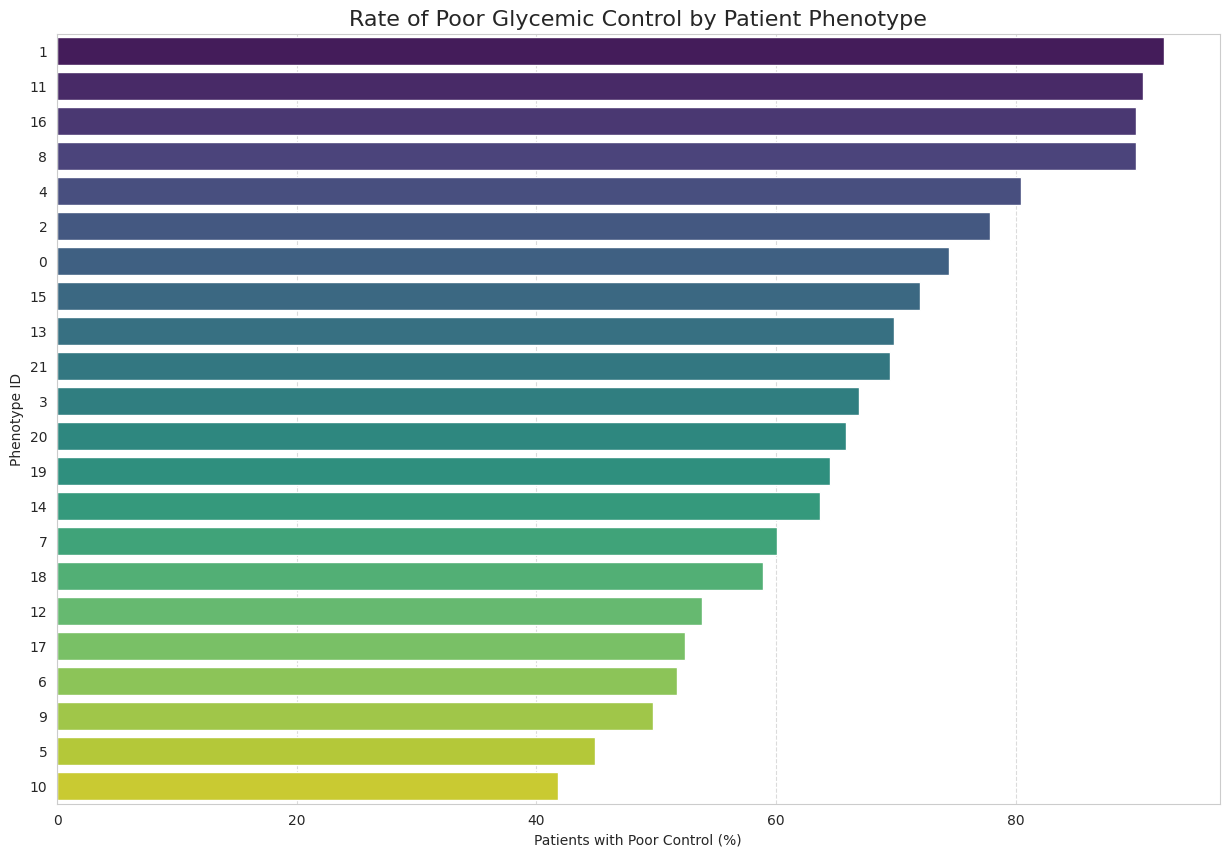

In [ ]:
# --- 1. Profile the Discovered Phenotypes ---
# We will analyze the phenotypes using our sampled data
profiling_vars = continuous_vars + ['Glycemic_control']

# Group by phenotype and calculate the mean for profiling variables
phenotype_profile = df_sample.groupby('phenotype')[profiling_vars].mean()

# Add the size of each phenotype
phenotype_profile['size'] = df_sample.groupby('phenotype').size()

# Rename outcome column for clarity
phenotype_profile.rename(columns={'Glycemic_control': 'poor_control_rate'}, inplace=True)

# Sort by the rate of poor control to identify highest and lowest risk groups
phenotype_summary = phenotype_profile.sort_values('poor_control_rate', ascending=False)

# Filter out the 'noise' cluster (label -1) for our analysis
phenotype_summary_filtered = phenotype_summary[phenotype_summary.index != -1]

print("--- Clinical Profiles of Discovered Phenotypes (Sorted by Risk) ---")
display(phenotype_summary_filtered)

# --- 2. Test for Association between Phenotype and Outcome ---
# A Chi-squared test will determine if phenotype membership is related to outcome
contingency_table = pd.crosstab(df_sample['phenotype'], df_sample['Glycemic_control'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print("\n--- Statistical Test of Association ---")
print(f"Chi-Squared Test p-value: {p:.4g}")
if p < 0.001:
    print("The association between the discovered phenotypes and 3-year glycemic control is highly statistically significant.")
else:
    print("The association is not statistically significant.")

# --- 3. Visualize the Outcome Rates by Phenotype ---
plt.figure(figsize=(15, 10))
# Convert rate to percentage for the plot
plot_data = (phenotype_summary_filtered['poor_control_rate'] * 100).sort_values(ascending=False)

# Create the bar plot
sns.barplot(x=plot_data.values, y=plot_data.index.astype(str), orient='h', palette='viridis')

plt.title('Rate of Poor Glycemic Control by Patient Phenotype', fontsize=16)
plt.xlabel('Patients with Poor Control (%)')
plt.ylabel('Phenotype ID')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the plot
plt.savefig('phenotype_outcomes.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as 'phenotype_outcomes.png'.")
plt.show()

**Interpretation:**

The final step of our analysis powerfully demonstrates the clinical utility of our unsupervised discovery approach. The discovered phenotypes are not just statistically distinct; they are profoundly associated with long-term patient outcomes.

*   **Statistically Validated Discovery:** The **Chi-Squared p-value of 0** confirms with extremely high confidence that the discovered phenotypes are clinically relevant. Membership in a particular data-driven subgroup is significantly associated with the likelihood of achieving long-term glycemic control.

*   **Dramatic Risk Stratification:** The bar chart vividly illustrates a clear risk gradient across the phenotypes. The rate of poor glycemic control ranges from a staggering **92% in Phenotype 1** down to a much more favorable **42% in Phenotype 10**. This data-driven stratification is far more granular and powerful than a simple high/low-risk classification could ever be.

*   **Emergence of Clinical Personas:** By examining the profiling table alongside the risk chart, we can create data-driven "personas" for these patient groups:
    *   **Highest-Risk Phenotypes (#1, #11, #16, #8): "Severe Uncontrolled Hyperglycemia at Onset"**. These groups are defined by a very **high mean baseline HbA1c (ranging from 8.8% to 9.3%)**. Phenotype #16 is also notably younger (mean age 45), suggesting a particularly aggressive disease course.
    *   **Lowest-Risk Phenotypes (#5, #10): "Mild, Well-Managed Hyperglycemia"**. These groups have the **lowest mean baseline HbA1c (around 6.9%)**. Clinically, these are patients diagnosed at an earlier or less severe stage, and this favorable starting point is the strongest determinant of their positive long-term outcome.
    *   **Interesting Outliers (e.g., #13): "Extreme Hyperglycemia with Aggressive Response"**. Phenotype #13 is fascinating. It has the **highest baseline HbA1c by far (12.8%)** but only a 70% rate of poor control. The key lies in its massive `Hba1c_change` (1.55), indicating a dramatic response to initial therapy. This appears to be a group with severe initial presentation but high treatment responsiveness.

**Phase 3 Conclusion:** Our unsupervised analysis has successfully moved beyond prediction to genuine discovery. We have demonstrated that the umbrella diagnosis of "new-onset diabetes" contains numerous, distinct clinical phenotypes. These data-driven subgroups are not only identifiable but also have vastly different prognoses, paving the way for a future of more personalized risk stratification and tailored therapeutic strategies.

### **Section 5: Discussion & Conclusion**

*(This would be a Markdown cell in your notebook)*

This project applied a comprehensive, multi-phase machine learning framework to a large, real-world cohort of patients with new-onset diabetes. By progressing systematically from prediction to explanation and finally to discovery, we have generated several key insights with significant clinical implications.

### **5.1. Summary of Key Findings**

1.  **High-Accuracy Prediction is Achievable:** We successfully developed a Neural Network model capable of predicting 3-year glycemic control with high fidelity, achieving a final **AUROC of 0.892** on an unseen test set. The model demonstrated a clinically favorable profile, correctly identifying 91% of patients who would ultimately have poor control.

2.  **Glycemic Trajectory is a Critical Predictor:** Our Explainable AI (XAI) analysis revealed that beyond a patient's baseline `HbA1c`, their **glycemic change within the first year** was the second most important predictive feature. This highlights that a patient's early response to therapy is a powerful prognostic indicator that dynamic models can effectively capture.

3.  **Medication Intensity Serves as a Proxy for Disease Severity:** The XAI analysis also showed that the prescription of potent medications, particularly various types of insulin, was a strong predictor of poor long-term control. This demonstrates the model's sophistication in learning that the *need* for intensive therapy is a robust proxy for the underlying severity of the disease.

4.  **New-Onset Diabetes is Not a Monolithic Condition:** Our unsupervised analysis discovered **22 distinct clinical phenotypes** within the patient sample. These data-driven subgroups were not random but were strongly and significantly associated with long-term outcomes. The risk of poor glycemic control varied dramatically across these groups, from as high as 92% in the most severe phenotype to as low as 42% in the mildest.

### **5.2. Clinical Implications**

The findings from this research have several potential applications in clinical practice:

*   **Early Risk Stratification:** A deployed version of our predictive model could serve as a powerful clinical decision support tool, automatically flagging patients at high risk for poor long-term control at the time of their diagnosis. This would allow for the proactive allocation of resources, such as more frequent follow-ups, specialist consultations, or advanced therapeutic interventions.
*   **Personalized Medicine:** The discovery of distinct patient phenotypes opens the door to a more personalized approach to diabetes management. Rather than a one-size-fits-all strategy, clinicians could tailor treatment plans based on a patient's specific phenotype (e.g., "Severe Dyslipidemia with Poor Glycemic Trajectory" vs. "Mild, Well-Managed Hyperglycemia").
*   **Improved Clinical Trial Design:** The ability to identify these granular patient subgroups could significantly improve the design of clinical trials by allowing researchers to enroll more homogeneous patient populations, potentially leading to clearer and more powerful trial results.

### **5.3. Limitations & Future Work**

This study, while comprehensive, has several limitations. The analysis is retrospective and based on data from a single province in Turkey, which may limit the generalizability of the findings to other populations. The dataset also lacks information on socioeconomic status, lifestyle factors (diet, exercise), and medication adherence, which are known to influence glycemic control.

Future work should focus on:
*   **External Validation:** Testing the performance of our predictive model and the stability of the discovered phenotypes on a different, external patient cohort.
*   **Prospective Studies:** Designing prospective trials to test whether care guided by these predictive and phenotypic insights leads to improved patient outcomes.
*   **Feature Enrichment:** Incorporating additional data sources, such as genomics, continuous glucose monitoring (CGM) data, or patient-reported outcomes, to further refine the models and discover even more granular phenotypes.

### **5.4. Final Conclusion**

This project successfully demonstrates the power of a multi-layered machine learning approach in transforming large-scale electronic health record data into actionable clinical knowledge. We have shown that it is possible not only to accurately predict long-term outcomes in new-onset diabetes but also to understand the clinical logic behind those predictions and discover novel, prognostically significant patient subgroups. These data-driven methods hold immense promise for ushering in a new era of proactive, personalized, and more effective diabetes care.

### **Section 6: References**

The dataset used in this analysis was made publicly available and should be cited as:

Gulkesen, Kemal Hakan; Ülgü, Mustafa Mahir; Mutlu, Begum; Akünal, Abdullah; Ayvalı, Mustafa Okan; Akyürek, Özen; Birinci, Şuayip; Balcı, Mustafa Kemal; Sezer, Ebru (2024), “Machine Learning for Prediction of Glycemic Control in Diabetes Mellitus”, Mendeley Data, V2, doi: 10.17632/rr4rzzrjfc.2